In [ ]:
from __future__ import print_function
from __future__ import division

import cv2
import numpy as np

from timeit import default_timer as tmr # timer for performance check

# reshape an image or a collection of images to match convolution matrix

In [2]:
def resize_keep_ratio(im, newsize, pad=2): # resize image to the center or newsize image with keeping its ratio and leaving padding around
    tcg = np.zeros(newsize)
    nh, nw = newsize
    h, w = im.shape
    h, w = (nh, nh * w//h) if h>w else (nw * h//w, nw)
    ttcg = cv2.resize(im.astype('uint8'), (w-pad*2, h-pad*2))
    tcg[(len(tcg)-h)//2+pad:(len(tcg)-h)//2+h-pad, (len(tcg[0])-w)//2+pad:(len(tcg[0])-w)//2+w-pad] = ttcg
    return tcg

def reshape(x, shape=None):
    ''' reshape a 2D image or an array of 2D images into matching shape to fit Keras image data format '''
    global img_rows, img_cols
    if not shape: shape = img_rows, img_cols
    if type(x) in (list, tuple): x = np.array(x)
    iscoll = len(x.shape) != 2
    
    from keras import backend as K
    iscf = K.image_data_format() == 'channels_first'
    input_shape = (1, *shape) if iscf else (*shape, 1)
    
    if not iscoll and x.shape != shape: x = resize_keep_ratio(x, shape)
    _reshape = lambda x: x.reshape(x.shape[0] if iscoll else 1, *((1, *shape) if iscf else (*shape, 1)))
    
    return [_reshape(v) for v in x] if iscoll else _reshape(x), input_shape

In [3]:
## theano setup code
# from os import environ
# environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda,floatX=float32,cnmem=1"
# import theano
# theano.config.device='cuda'
# print(theano.config.device)
# theano.config.floatX='float32'

import tensorflow as tf
sess = tf.Session()

import keras
from keras import backend as K

K.set_session(sess)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Lambda
from tensorlayer.layers import DropconnectDenseLayer

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

t = tmr()
from keras.datasets import mnist
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

(x_train, x_test), input_shape = reshape([x_train, x_test])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')

# if model: del model
with tf.device('/gpu:0'):
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    print(tmr()-t, 'seconds took to mnist preprocessing') # 0.00146
    t = tmr()
    ### load model config from file
    with open('mnist_cnn.yaml') as f:
        from keras.models import model_from_yaml
        model = model_from_yaml(f.read())
    print(tmr()-t, 'seconds took to load model configuration') # 0.176
    t = tmr()

#     model = Sequential()
    
#     model.add(Conv2D(32, kernel_size=(3, 3),
#                      activation='relu',
#                      input_shape=input_shape))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    print(tmr()-t, 'seconds took to compile') # 0.02
#     t = tmr()
#     with open('mnist_cnn.yaml','w') as f:
#         f.write(model.to_yaml())
#     print(model.summary())
    model.load_weights('./mnist_cnn.h5')
    # output_tensor = model.output

    # DropconnectDenseLayer(network, keep=0.8, n_units=800, act=tf.nn.relu, name='dropconnect_relu1')
    # DropconnectDenseLayer(network, keep=0.5, n_units=800, act=tf.nn.relu, name='dropconnect_relu2')
    # DropconnectDenseLayer(network, keep=0.5, n_units=800, act=tf.nn.relu, name='dropconnect_relu2')
    
    print(tmr()-t, 'seconds took to load weight') # 0.34

#     t=tmr()
#     model.fit(x_train, y_train,
#               batch_size=batch_size,
#               epochs=epochs,
#               verbose=1,
#               validation_data=(x_test, y_test))
#     print(tmr()-t, 'seconds took to fit') # very long -> 58.05
#     model.save_weights('mnist_cnn.h5')
    
    t=tmr()
    score = model.evaluate(x_test, y_test, verbose=0)
    print(tmr()-t, 'seconds took to evaluate') #7.9 -> 1.33
# 7.127567801999248 seconds took to evaluate
print('Test loss:', score[0])
print('Test accuracy:', score[1]) # 99.03% -> 99.19%

Using TensorFlow backend.


0.3347826820008777 seconds took to mnist preprocessing
0.1561088029993698 seconds took to load model configuration
0.021441309998408542 seconds took to compile
0.7169588829983695 seconds took to load weight
1.6868023770002765 seconds took to evaluate
Test loss: 0.0256743601905
Test accuracy: 0.9919


In [4]:
print('output shape:', model.output_shape)
model.summary()
# model.get_config()
# model.get_weights()

output shape: (None, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)           

# DCGAN testing
### references
    1. https://github.com/ctmakro/DCGAN-Keras
    2. https://arxiv.org/pdf/1611.08789.pdf
    3. https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
    4. https://github.com/kyloon/dcgan

# graph setup & utilities definition

In [51]:
%matplotlib inline
# %matplotlib notebook

from PIL import Image
import PIL.ImageOps

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

matplotlib.rcParams['figure.figsize'] = [25, 20] # [6.0, 4.0]

def imwin(im, win):
    im=im.copy()
    (y0,x0),(y1,x1) = win
    h, w = y1 - y0, x1 - x0
    im[y0+1:y1-1, x0+1:x1-1] //= 2
    im[y0:y1, x0] = im[y0:y1, x1] = im[y0, x0:x1] = im[y1, x0:x1] = np.max(im)
    return im

def imdiv(im, d0,s0,d1,s1, win=None):
    if win is not None:
        im = imwin(im, win)
    l0, l1 = map(len, (im, im[0]))
    return im[int(l0//d0*s0):int(l0//d0*(s0+1)), int(l1//d1*s1):int(l1//d1*(s1+1))]

def imshow_now(im, wait=True, msg=''):
    from IPython import display
    plt.imshow(im)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    if wait:
        return input(msg) if msg else input('press enter to continue')
#     plt.waitforbuttonpress()

def display_array_table(obj, imsize=None, force_col=None):
    if force_col and force_col>0:
        o, line=[], []
        i=0
        for l in obj:
            for c in l:
                line.append(c)
                i+=1
                if i>0 and i % force_col == 0:
                    o.append(line)
                    line = []
        obj = o
#         print(o)
    def html_format_obj(o):
        from base64 import b64encode
        from io import BytesIO
        t = type(o)
        if t is np.ndarray or issubclass(t, Image.Image):
            if t is np.ndarray: o = Image.fromarray(o)
            buf = BytesIO()
            if imsize: o = o.resize(imsize)
            o.save(buf, format='PNG')
            o = '<img src="data:image/png;base64, %s" />' % b64encode(buf.getvalue()).decode()
        return str(o)
    html = '<table><tr>{}</tr></table>'.format(
            '</tr><tr>'.join(
                '<td style="text-align:center;">{}</td>'.format('</td><td style="text-align:center;">'.join(html_format_obj(v) for v in row)) for row in obj)
            )
#     print(html)
    ddisplay(HTML(html))

def imsave(im, fname):
    if type(im) is np.ndarray:
        im = Image.fromarray(im)
    im.convert('RGB').save(fname+'.webp', lossless=True)

In [83]:
def save_arr(fname, arr):
    np.save(fname+'.npy', arr)

def load_arr(fname):
    return np.load(fname+'.npy')
    
def save_set(name, x, y):
    list(map(lambda s, v : save_arr(name+'_'+s, v), ('x','y'), (x,y)))
    
def load_set(name):
    return np.array(list(map(lambda s: load_arr(name+'_'+s), ('x', 'y'))))

In [1213]:
def predict_rst(m, arr, minprd=1):
    '''returns predicted number
       returns None if it's not predictable.
       m: model, arr:B/W image to predict by'''
#     l=m.predict_proba(arr).tolist()[0]
    l=m.predict(arr)
#     print(l)
    if minprd is None:
        return np.where(l==np.max(l))[1][0]
    return None if np.max(l) < minprd else np.where(l==np.max(l))[1][0]

# test learned model

In [8]:
# print()

# noise reduce with closing

In [9]:
# plt.subplot(121).imshow(imdiv(gray, 8, 4, 7, 3))
def noise_reduce(im):
    #gray = cv2.fastNlMeansDenoising(gray, 10)
    im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, np.ones((2,2), np.uint8))
    im = cv2.bilateralFilter(im, 4, 25, 50)
    # gray = cv2.filter2D(gray,-1, np.ones((3,3),np.float32)/9)
    # gray = cv2.GaussianBlur(gray, (3,3),0)
    return im


# plt.subplot(122).imshow(imdiv(gray, 8, 4, 7, 3))

#gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, np.ones((2,2), np.uint8))
#plt.subplot(122).imshow(imdiv(gray, 4, 1, 4, 1.5))
#ret,gray = cv2.threshold(gray,)
#gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 11, 2)
#plt.subplot(133).imshow(gray[len(gray)//4:len(gray)*2//4,:len(gray[0])//4])
#gray = cv2.erode(gray, np.ones((4,4),np.uint8))
#Image.fromarray(gray).show()
#plt.subplot(122).imshow(gray[len(gray)//3:len(gray)*2//3,:len(gray[0])//2])

# convert image to grayscale

In [10]:
def gray_img(im):
#     print(im, im.mode, im.mode=='1')
    if im.mode == '1':
        im = PIL.ImageOps.invert(im.convert('L'))
    else:
        im = PIL.ImageOps.invert(im).convert('L')
    #img = img.filter(ImageFilter.FIND_EDGES)
    return noise_reduce(np.asarray(im))
    #gray = cv2.cvtColor(np.asarray(img),cv2.COLOR_RGB2GRAY)

# plt.subplot(121).imshow(imdiv(np.asarray(testimg), 8, 4, 7, 3))
# plt.subplot(122).imshow(imdiv(gray, 8, 4, 7, 3))

# binaraize with otsu's method

In [11]:
def gray2bin(gray, lim=None):
    gray = gray.copy()
    if not lim:
#         blur = cv2.GaussianBlur(gray,(5,5),0)
#         # find normalized_histogram, and its cumulative distribution function
#         hist = cv2.calcHist([blur],[0],None,[256],[0,256])
#         hist_norm = hist.ravel() / hist.max()
#         Q = hist_norm.cumsum()
#         bins = np.arange(256)
#         fn_min = np.inf
#         thresh = -1
#         for i in range(1,256):
#             p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
#             q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
#             b1,b2 = np.hsplit(bins,[i]) # weights
#             # finding means and variances
#             m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
#             v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
#             # calculates the minimization function
#             fn = v1*q1 + v2*q2
#             if fn < fn_min:
#                 fn_min = fn
#                 thresh = i
        # find otsu's threshold value with OpenCV function
        otsuret, otsu = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        return otsu, otsuret
    else:
        return ((gray>lim)*255).astype('uint8'), lim

# plt.subplot(121).set_title('grayscale')
# plt.subplot(121).imshow(imdiv(gray, 8, 4, 7 ,3))
# plt.subplot(121).axis('off')

# otsu, otsuret = gray2bin(gray)
# plt.subplot(122).set_title('otsu')
# plt.subplot(122).imshow(imdiv(otsu, 8, 4, 7 ,3))
# plt.subplot(122).axis('off')
# print(otsuret, 'as binarize edge by otsu\'s method')

#ret, bnw = cv2.threshold(gray,50,255,cv2.THRESH_BINARY)
#plt.subplot(122).set_title('global')
#plt.subplot(122).imshow(imdiv(bnw, 8, 4, 7 ,3))

# find contours from binary image

In [12]:
#plt.subplot(121).imshow(imdiv(gray, 8, 4, 7, 3))
#edges = cv2.Canny(gray,otsuret,(255+otsuret)//2,apertureSize = 3)
def get_contours(im):
    return cv2.findContours(im.copy().astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#hulls = contours.copy()

#contours = cv2.convexHull(contours)
# h, w = gray.shape
# imc = np.zeros((h, w))

# for component in zip(contours, hierarchy):
#    currentContour, currentHierarchy = component
#    x,y,w,h = cv2.boundingRect(currentContour)
#    if currentHierarchy[2] < 0:
#        # these are the innermost child components
#        cv2.rectangle(imc,(x,y),(x+w,y+h),255,1)
#    elif currentHierarchy[3] < 0:
#        # these are the outermost parent components
#        cv2.rectangle(imc,(x,y),(x+w,y+h),255,1)

#print(h, w)

# get indexes of contours which are larger than some limit to find outlines of tables

In [13]:
def get_outline_inds(contours, hierarchy, minarea, *, trgParent=None):
    hierarchy = hierarchy[0]
    outlines = []
    for i in range(len(contours)):
    #    #contours[i] = cv2.convexHull(contours[i])
        #if hierarchy[i][3] == 0:
        prt = hierarchy[i][3]
        if (trgParent is not None and prt == trgParent) and cv2.contourArea(contours[i])> minarea:
            #contours[i] = cv2.approxPolyDP(contours[i], 0.001*cv2.arcLength(contours[i],True), True)
            #cv2.drawContours(imc, contours, i, 255, 1)
            outlines.append(i)
            #print(len(contours[i]))
    return outlines

#outlines = [contours[i] for i in outline_inds]
#cv2.drawContours(imc, contours, -1, 255, 1)
#plt.subplot(122).imshow(imdiv(imc, 8, 0, 7, 0))

#print(len(contours), 'contours found')
#plt.subplot(122).imshow(imdiv(hulls, 8, 4, 7, 3))

#plt.subplot(121).imshow(imdiv(otsu, 8, 4, 7, 3))
#plt.subplot(122).imshow(imdiv(ctr, 8, 4, 7, 3))

# sort outlines by its area in reversed order to find largest tables

In [14]:
#plt.subplot(121).imshow(imdiv(otsu, 4, 3, 4, 0))
#plt.subplot(122).imshow(imdiv(imc, 4, 3, 4, 0))
#Image.fromarray(imc).show()

#areas = [cv2.contourArea(x) for x in outlines]
#sorted_outlines = np.array(outlines)[np.argsort(areas)]

#outlines.sort(key = lambda x : cv2.contourArea(areas[x]))
#print(areas, np.argsort(areas))
def split_tables(contours, outline_inds):
    sort_outline_inds = lambda c, o:[ x for y, x in sorted(zip([cv2.contourArea(c[i]) for i in o], o), reverse=True) ]
    sorted_outline_inds = sort_outline_inds(contours, outline_inds)
#     print([cv2.contourArea(contours[i]) for i in sorted_outline_inds])
    #im = np.zeros(gray.shape)
    table_inds = []
    table_bnds = []
    #biggest_y = None
    s = 0

    for i in range(len(sorted_outline_inds)):
        #if i > 4:break
        #cv2.drawContours(im, sorted_outlines, i, 255, 10)
        b = x,y,w,h = cv2.boundingRect(contours[sorted_outline_inds[i]])
        #if i==0 : biggest_y = y
        #elif biggest_y*2 < y: continue # table index 2, 3 would be unnecessary tables

        #cv2.rectangle(im, (x,y),(x+w,y+h), 255, cv2.FILLED)
        #im[y:y+h, x:x+w] = gray[y:y+h, x:x+w]
        #tables.append(gray[y:y+h, x:x+w].copy())
        table_inds.append(sorted_outline_inds[i])
        table_bnds.append(b)
        #tables[s] = otsu[y:y+h, x:x+w]
    
    return table_inds, table_bnds

# print(table_inds)
# print(table_bnds)

# assert table_bnds[0][0] < table_bnds[1][0] # middle tables' X are bigger's - smaller's
# assert table_bnds[4][0] < table_bnds[5][0] # top tables' X are bigger's - smaller's

#plt.subplot(121).imshow(gray)
#plt.subplot(122).imshow(tables[0])
#for i in np.argsort([cv2.contourArea(x) for x in outlines]):
#    print(cv2.contourArea(outlines[i]))

# check tables found

### note between numba and numbapro(deprecated)
`from numbapro import cuda` -> `from accelerate import cuda`
`from numbapro import vectorize` -> `from numba import vectorize`
`@vectorize(..., target='gpu')` -> `@vectorize(..., target='cuda')`

# image thinning

## references
 - http://answers.opencv.org/question/3207/what-is-a-good-thinning-algorithm-for-getting-the-skeleton-of-characters-for-ocr/
  - http://www-prima.inrialpes.fr/perso/Tran/Draft/gateway.cfm.pdf
 - https://github.com/linbojin/Skeletonization-by-Zhang-Suen-Thinning-Algorithm/blob/master/thinning.py

In [15]:
from multiprocessing import Pool
# from pathos.multiprocessing import ProcessingPool

def neighbours(y,x,img):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return list(map(lambda _y, _x: img[_y, _x], (y_1, y_1, y, y1, y1, y1, y, y_1), (x, x1, x1, x1, x, x_1, x_1, x_1)))
#                 [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
#                 img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
#     n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
#     return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) ) # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)
    return str(list(map(lambda v:int(bool(v)), neighbours + [neighbours[0]]))).count('0, 1')

Image_Thinned=None
def zhangSuenAlg(arg):
    y, x, si = arg
    global Image_thinned
    n = neighbours(y, x, Image_Thinned)
    return (y, x) if (Image_Thinned[y,x]  and    # Condition 0: Point P1 in the object regions
        2 <= list(map(bool,n)).count(True) <= 6   and    # Condition 1: 2<= N(P1) <= 6
        transitions(n) == 1 and    # Condition 2: S(P1)=1
        0 in (n[0], n[2], n[4 if not si else 6])  and    # Condition 3
        0 in (n[2 if not si else 0], n[4], n[6])) else None         # Condition 4

def zhangSuen(image):
    global Image_Thinned
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing = 1        #  the points to be removed (set as 0)
    sx = sy = 1
    while changing:   #  iterates until no further changes occur in the image
        changing = 0
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for si in range(2): # sub iteration
            sichange = []
            args = []
            for y in range(1, rows - 1):                     # No. of  rows
                for x in range(1, columns - 1):            # No. of columns
                    args.append((y, x, si))
#                     if zhangSuenAlg((y, x, si)):
#                         sichange.append((y, x))
            with Pool(8) as p:
                sichange = [v for v in p.map(zhangSuenAlg, args) if v]
            changing += len(sichange)
            for y, x in sichange:
                Image_Thinned[y,x] = 0
    return Image_Thinned

# faster image thinning (Zhang-Wang)
 - http://www.uel.br/pessoal/josealexandre/stuff/thinning/ftp/zhang-wang.pdf

# test zhangSuen()
### It took about 5 seconds for a 300x300 pixels.
### It means we need to optimize zhangSuen() with real parallelization

# use zhang-suen to simplify table

# custom linearization filter
### it uses both SQDIFF template matching(fast, inaccurate) and loosely applied fft matching(slow, accurate)

In [16]:
from multiprocessing import Pool

_match, _pattern = None, None
def match_pattern(args):
    global _match, _pattern
    y0, x0, y1, x1 = args
#     h, w = map(len, (_pattern, _pattern[0]))
#     y1, x1 = y0+h, x0+w
    return (y0, x0) if np.array_equal(_match[y0:y1, x0:x1], _pattern) else None

def match_2d_fft(im, pattern):
    global _match, _pattern
    _match, _pattern = im, pattern
    from scipy.signal import fftconvolve
    f = fftconvolve(np.array(im).astype(np.float),np.array(pattern).astype(np.float),mode='valid')
    h, w = map(len, (pattern, pattern[0]))
    for m in range (6,0,-1):
        ftt = np.transpose(np.where((m<=f) & (f<m+1)))
        rst = []
#         args = []
#         print(m, ':', len(f), '/', len(im)*len(im[0]), '=',len(f)/(len(im)*len(im[0]))*100, '%')
        for y, x in ftt:
            if np.array_equal(im[y:y+h, x:x+w], pattern):
                rst.append((y, x))
#                 args.append((y, x, y+h, x+w))
#         with Pool(8) as p:
#             rst = [v for v in p.map(match_pattern, args) if v]
        if len(rst):
#             print(m)
            return rst
#     if not len(rst): print ('not found')
    return rst
    # print(thin[340:345+20,405:415+20].astype(np.uint8))

def match_2d_template(im, pattern):
    from cv2 import matchTemplate as cv2m
    R,C = np.where(0 == cv2m(np.array(im).astype(np.uint8),np.array(pattern).astype(np.uint8),cv2.TM_SQDIFF))
#     print(len(R), 'found')
    return list(zip(R,C))

def replace_2d(im, kernel, tos, use_template=False):
    kernel, tos = map(np.array, (kernel, tos))
    if kernel.shape != tos.shape:
        raise Exception('shape of kernel ' + str(kernel.shape)+' doesn\'t match '+str(tos.shape) )
    cnt = 0
    while True:
        glitches = (match_2d_template if use_template else match_2d_fft)(im, kernel)
        if not len(glitches): break
        cnt += len(glitches)
#         if not len(glitches[0]): break
#         cnt += glitches[0]
#         print(len(glitches), 'patterns found')
        for y, x in glitches:
            im[y:y+len(tos),x:x+len(tos[0])] = tos
#     print(cnt, 'replaced')
    return cnt

def replace_2d_both(im, kernel, tos):
    replace_2d(im, kernel, tos, True)
    replace_2d(im, kernel, tos)

In [17]:
# fil_otsu = lin_filter(otsu)
# thin2 = thin.copy()

replace_templates = [[[
#wierdos
## ear shapes
[1,1,1],
[1,0,1],
[1,0,0],
[1,0,1],
[1,1,1]], [
[0,0,1]]*5
], [[
[1,1,1],
[1,0,1],
[1,0,0],
[1,0,0],
[1,0,1],
[1,1,1]], [
[0,0,1]]*6
], [[
[0,0,0,1],
[0,1,1,1],
[0,1,0,1],
[0,1,0,0],
[0,1,0,0],
[0,1,0,0],
[0,1,0,0],
[0,1,0,0],
[0,1,0,1],
[0,1,1,1]], [
[0,0,0,1]]*10
], [[
[0,0,0,1],
[0,1,1,1],
[0,1,0,1],
[0,1,0,0],
[0,1,0,0],
[0,1,0,0],
[0,1,0,1],
[0,1,1,1]], [
[0,0,0,1]]*8
], [[
[1,1,1],
[1,0,1],
[1,0,0],
[1,0,0],
[1,0,0],
[1,0,0],
[1,0,1],
[1,1,1]], [
[0,0,1]]*8
], [[
[1,0,0],
[1,0,1],
[1,1,1],
[1,0,1],
[1,0,0]], [
[1,0,0]]*5
], [[
[1,0,0],
[1,0,1],
[1,0,1],
[1,1,1],
[1,0,1],
[1,0,0]], [
[1,0,0]]*6
], [[
[0,0,0,0,0,0],
[0,1,1,1,1,0],
[1,1,0,0,1,1],
[0,0,0,0,0,0]], [
[0,0,0,0,0,0],
[0,0,0,0,0,0],
[1,1,1,1,1,1],
[0,0,0,0,0,0]]
#cross
], [[
[0,0,0,1],
[0,0,0,1],
[1,1,0,0],
[0,1,0,0]], [
[0,0,1,1],
[0,0,1,0],
[1,1,1,0],
[0,0,1,0]]
], [[
[0,0,0,1],
[0,0,0,1],
[1,1,0,0],
[0,1,0,0]], [
[0,0,1,1],
[0,0,1,0],
[1,1,1,0],
[0,0,1,0]]
#further lines 
], [[
[1,1,0,1],
[0,0,0,0],
[0,0,1,0]], [
[1,1,1,1],
[0,0,0,0],
[0,0,0,0]]
#simple horizontal lines
], [[
[1,0,1,1,1],
[0,1,0,0,0]], [
[1,1,1,1,1],
[0,0,0,0,0]]
], [[
[1,1,0,1,1],
[0,0,1,0,0]], [
[1,1,1,1,1],
[0,0,0,0,0]]
], [[
[0,0,0],
[1,1,0],
[0,0,1]], [
[0,0,0],
[1,1,1],
[0,0,0]]
], [[
[0,0,0,0],
[0,1,1,1],
[1,0,0,0]], [
[0,0,0,0],
[1,1,1,1],
[0,0,0,0]]
], [[
[0,1,1,1,1,0],
[1,1,0,0,1,1]], [
[0,0,0,0,0,0],
[1,1,1,1,1,1]]
], [[
[0,0,1,1,0,0],
[1,1,0,0,1,1]], [
[0,0,0,0,0,0],
[1,1,1,1,1,1]]
], [[
[1,1,0,1,1],
[0,0,1,0,0]],  [
[1,1,1,1,1],
[0,0,0,0,0]]
#simpel vertical lines
], [[
[0,1,0],
[0,1,0],
[1,0,0]], [
[0,1,0]]*3,
], [[
[0,1,0],
[0,1,0],
[0,0,1]], [
[0,1,0]]*3
], [[
[0,1,0],
[0,0,1],
[0,1,0]], [
[0,1,0]]*3
], [[
[0,1,0],
[1,0,0],
[0,1,0]], [
[0,1,0]]*3,
], [[
[0,1,0],
[0,0,1],
[0,0,1],
[0,1,0]], [
[0,1,0]]*4,
# cross
], [[
[0,0,1,0,0],
[1,1,1,0,1],
[0,0,1,1,0],
[0,0,1,0,0]],  [
[0,0,1,0,0],
[1,1,1,1,1],
[0,0,1,0,0],
[0,0,1,0,0]]
], [[
[0,0,1,0,0],
[1,1,1,1,1],
[0,0,0,1,0],
[0,0,1,0,0]],  [
[0,0,1,0,0],
[1,1,1,1,1],
[0,0,1,0,0],
[0,0,1,0,0]]
], [[
[0,1,0,0],
[1,1,1,1],
[0,0,1,0],
[0,1,0,0]],  [
[0,1,0,0],
[1,1,1,1],
[0,1,0,0],
[0,1,0,0]]
], [[
[1,0,1,1],
[1,1,0,0],
[1,0,0,0]],  [
[1,1,1,1],
[1,0,0,0],
[1,0,0,0]]
], [[
[0,1,0],
[1,1,1],
[0,0,0],
[0,1,0]], [
[0,1,0],
[1,1,1],
[0,1,0],
[0,1,0]]
], [[
[0,0,1,0,0],
[0,0,1,0,0],
[1,1,1,1,1],
[0,0,1,0,0],
[0,0,0,1,0],
[0,0,0,1,0]], [
[0,0,1,0,0],
[0,0,1,0,0],
[1,1,1,1,1],
[0,0,1,0,0],
[0,0,1,0,0],
[0,0,1,0,0]]
], [[
[1,1,1,1],
[0,0,0,1],
[0,0,1,0],
[0,0,1,1]], [
[1,1,1,1],
[0,0,0,1],
[0,0,0,1],
[0,0,0,1]]
], [[
[0,0,0,1],
[1,1,0,1],
[0,0,0,1]], [
[0,0,0,1],
[1,1,1,1],
[0,0,0,1]]
], [[
[0,0,0,0,0],
[1,1,1,1,1],
[0,0,0,0,0],
[0,0,1,0,0],
[0,0,1,0,0]], [
[0,0,0,0,0],
[1,1,1,1,1],
[0,0,1,0,0],
[0,0,1,0,0],
[0,0,1,0,0]]
#corner
], [[
[0,0,0,0],
[1,1,0,0],
[0,0,0,0],
[0,1,0,0],
[0,1,1,0]], [
[0,0,0,0],
[1,1,1,1],
[0,0,0,1],
[0,0,0,1],
[0,0,0,1]]
], [[
[0,0,0,0],
[0,0,1,1],
[0,0,0,0],
[0,1,0,0],
[0,1,0,0]], [
[0,0,0,0],
[0,1,1,1],
[0,1,0,0],
[0,1,0,0],
[0,1,0,0]]
], [[
[0,0,0,0,1,0],
[0,0,0,0,1,0],
[0,0,0,0,1,0],
[1,1,0,0,0,0],
[0,0,0,0,0,0]], [
[0,0,0,0,1,0],
[0,0,0,0,1,0],
[0,0,0,0,1,0],
[1,1,1,1,1,0],
[0,0,0,0,0,0]]
], [[
[0,0,0,0,1,0],
[0,0,0,0,1,0],
[0,0,0,0,1,0],
[1,1,1,0,1,0],
[0,0,0,0,0,0]], [
[0,0,0,0,1,0],
[0,0,0,0,1,0],
[0,0,0,0,1,0],
[1,1,1,1,1,0],
[0,0,0,0,0,0]]

]]

# radical traverse in array for finding most outer corner points

In [18]:
def radius(r=1, _max=-1, startDeg=0, rot=1):
    ''' :arg max: maximum radius distance to generate. -1(default) to inifite
        :arg rot: rotation direction (1:clockwise, -1:anticlockwise)
        :return: x, y '''
    rot = 1 if rot>0 else -1
    from math import sqrt, atan, pi, cos, sin
    from itertools import count
    for i in range(r, _max+1) if _max >=0 else count(r):
#     while not _max or r <= _max:
#         if _max and r >= _max: break
        for j in range(i+1):
            r = sqrt(i**2+j**2)
#             print('sqrt(',i,'**2', *('+', j, '**2) =') if j else (') =',), r)
            ds = atan(j/i) + deg2rad(startDeg)
            if 0 < j < i:
                dd = atan(i/j)-ds
                step=True
                l=[]
                for q in range(4): # on each quadrants
                    for x in range(2): # two mirrored axis
                        l.append((pi/2*q+ds+dd*x)*rot)
            else:
                l= np.linspace(ds, ds +rot*2*pi, 4, False)
#             for c in count(1):
#                 if ds + c*dd >= 2*pi:break
#                 print(ds+c*dd)
            for t in l:#np.linspace(ds, ds+(1 if rot else -1)*dd*(c-1), c):
                yield round(r*cos(t)), round(r*sin(t))
        i+=1

In [19]:
def enum_corner(arr, cor=0, rotation=1):
    # cor : corner to start (0:top-left, 1:top-right, 2:bottom-right, 3:bottom-left, -1:center)
    # rotation = 1 for clockwise, 0 for counter-clockwise
    yrng, xrng = len(arr), len(arr[0])#arr.shape
    if cor==-1:
        _x, _y = xrng//2-1, yrng//2-1
    else:
        _x, _y = 0 if cor==0 or cor==3 else (xrng-1), 0 if cor==0 or cor==1 else (yrng-1)
#     yield arr[_x,_y]
    yield _x, _y
    for x, y in radius(_max=max(yrng,xrng)):
        x+=_x
        y+=_y
        if 0<=x<xrng and 0<=y<yrng:
#             yield arr[y,x]
            yield x, y

In [20]:
def find_corner(im, cor=0, rotation=1, val=None, near=0):
    for x,y in enum_corner(im, cor, rotation):
        if (val is None and im[y, x]) or (val == im[y, x]):
            if near:
                nop = False
                for _x in range(near+1) if cor in (0,1,2,3) else range(-near, near+1):
                    if _x == 0 : continue
                    for _y in range(near+1) if cor in (0,1,2,3) else range(-near, near+1):
                        if _y == 0 : continue
                        v = im[y+(_y if cor in (0,1) else -_y), 1+x+(_x if cor in (0,3) else -_x)]
                        if (val is None and not v) or (val is not None and v!=val):
                            nop = True
                            break
                    if nop: break
                if nop:continue
            return y, x

# option1: get contour tree of selected table from precalculated contours

# option2: make new contour and hierarchy from thinned image
### chosen: because of applying expensive thinning process

In [21]:
# biggerthin = thin2.copy() #np.zeros((th+10, tw+10))
# np.copyto(biggerthin[5:th+5,5:tw+5], thin2.copy())
# _, tcontours, thierarchy = cv2.findContours(thin2.copy().astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# remove defections and find 90 degree corners from contour

In [593]:
# im6 = np.zeros(thin2.shape) #np.zeros((th+10, tw+10))
# im7 = np.zeros(thin2.shape) #np.zeros((th+10, tw+10))

from math import degrees as rad2deg, radians as deg2rad

def line_length(x0,y0,x1,y1):
    from math import sqrt
    return sqrt(abs(y1-y0)**2+abs(x1-x0)**2)

def line_slope(x0,y0,x1,y1):
    return (0 if y1==y0 else (float('inf') if y1>y0 else -float('inf'))) if x1==x0 else (y0-y1)/(x1-x0)

def line_equation(a, b, slope=None):
    if slope is None:slope = line_slope(*a, *b)
    if slope == float('inf') or slope == -float('inf'):
        assert a[0] == b[0] # x0 == x1
        return slope, a[0]
    ystart = a[1]-slope*a[0] # b=y-ax
    return slope, ystart

def line_intersection(ma, ba, mb, bb):
#     aa, ba = line_equation(*a)
#     ab, bb = line_equation(*b)
#     if aa == ab : return None
#     print(aa, ba, ab, bb)
    if type(ma) is float and (ma==float('inf') or ma==-float('inf')):
        return ba, ab*ba+bb
    elif type(ab) is float and (ab==float('inf') or ab==-float('inf')):
        x = bb
    else:
        x = (bb-ba)/(ma-mb)
    y = ma*x + ba
    print(y, mb*x +bb)
#     assert y==mb*x +bb
#     print(y, x)
    return x, y

deg90rad = deg2rad(90)

def line_angle(slope):
    if slope == float('inf'): return deg90rad
    elif slope == -float('inf'): return -deg90rad
    from math import atan
    return atan(slope)

# def line_angle(x0,y0,x1,y1):
#     from math import atan
#     if x1==x0:return deg2rad(90)*(1 if y0<y1 else -1)
#     return atan(line_slope(x0,y0,x1,y1))

# tcontours[:,:,0,:] -= tx, ty
def find_undefect_corners(im, tcontours):
    global margin
    _im = im//3
    im = np.zeros(im.shape)
    intsctcnt = 0
    # cv2.drawContours(im6, tcontours, -1, 127, 1)
    intersections = []

    for t in tcontours:
    #     t = c.copy()
    #     t[:,0,:] -= tx, ty
    #     cv2.drawContours(im6, [c], -1, 100, 1)
        t = cv2.approxPolyDP(t, 0.0011*cv2.arcLength(t,True), True)
    #     t = cv2.convexHull(t)
#         cv2.drawContours(im6, [t], -1, 255, 1)
    #     cv2.drawContours(im7, [t], -1, 255, 1)
    # im7 = np.zeros(im7.shape)
    # for t in tcontours:
    #     t = cv2.approxPolyDP(t, 0.0012*cv2.arcLength(t,True), True)
    #     cv2.drawContours(im7, [t], -1, 255, 1)

        if cv2.contourArea(t) < 550:continue
    #      for i in range(len(t)):
    #         t[i][0] = t[i][0][0] - x , t[i][0][1] - y
    #     print(len(t), t[0])
    #     t[:,0,:]-=(tx,ty)
    #     print(t)
        defects = cv2.convexityDefects(t, cv2.convexHull(t, returnPoints=False))
        for df in defects:
            s, e, f, d = df[0]
    #         print(s, e)
            t = np.concatenate((t[:s] , t[e-1:]))
        tt = []
        addedskip=False
        for i in range(len(t)):
            a, b = map(lambda v :tuple(t[v][0]), (i-1, i))
    #         ax, ay = t[i][0]
    #         bx, by = t[i+1][0]
    #         print(line_length(ax,ay,bx,by))
            if line_length(*a, *b) > 15:
    #             print(i, line_length(*t[i][0], *t[i+1][0]))
    #         if line_length(ax,ay,bx,by) > 4:
                cv2.line(im, a, b, 255*2//3)
                if not addedskip : tt.append(t[i-1])
                tt.append(t[i])
                addedskip=True
            else:
                addedskip=False
    #     print(t)
    #     print(tt)

        for i in range(len(tt)-3):
            (xa, ya), (xb, yb) = map(lambda v : tt[v][0], (i-1, i))
            m0 = line_slope(xa,ya,xb,yb)
            (xc, yc), (xd, yd) = map(lambda v : tt[v][0], (i+1, i+2))
            m1 = line_slope(xc,yc,xd,yd)
            angle_diff = abs(deg90rad-abs(line_angle(m0) - line_angle(m1)))
    #         print(angle_diff)
            if angle_diff<2:
    #             _, ba = line_equation((xa,ya), (xb, yb), m0)
    #             _, bb = line_equation((xc,yc), (xd, yd), m1)
    #             print(ba, bb)
    #             cv2.circle(im7, (ax,by), 2, 255, 1)
    #             print(line_intersection(m0,ba,m1,bb), xa, yc)
                x, y = xb, yb
                for j in range(2):
                    if 0<=x<len(im[0]) and 0<=y<len(im):
        #                 if line_length(xa,ya,xb,yb) > 4:
        #                     print(xa,ya,xb,yb, 'long line')
        #                 if line_length(xc,yc,xd,yd) > 4:
        #                     print(xc,yc,xd,yd, 'long line')
        #                 y, x=map(int,(y, x))
        #                 print(y, x)
                        nearmap = [im[y-margin, x-margin:x+margin].any(), #top
                                   im[y-margin:y+margin, x+margin].any(), #right
                                   im[y+margin, x-margin:x+margin].any(), #bottom
                                   im[y-margin:y+margin, x-margin].any()] #left
                        if not (nearmap.count(True) ==2 and ( # it allows corners
                                nearmap[0] == nearmap[2] == True or #top-bottom 
                                nearmap[1] == nearmap[3] == True )) and nearmap.count(True) >= 2 : #left-right
                            im[y, x] = 255
                            intersections.append((y, x)) #tuple(map(lambda v: int(np.around(v)), (ax, by))))
                    x, y = xc, yc
    #     cv2.drawContours(im6, np.array([tt]), -1, 255, 1)
        #if cv2.contourArea(t) > tw*th//200:
    return intersections, im

# print(type(tcontours), len(tcontours))
# cv2.drawContours(im6, tcontours, -1, 255, 1)
# print(len(intersections), 'intersections found')
# for i in range(len(thierarchy[0])):
#     nxt, prv, cld, prt = thierarchy[0][i]
#     if cv2.contourArea(tcontours[i])>tw*th//200:
#         #print(tcontours[i])
#         #cv2.boundingRect(tcontours[i])
#         cv2.drawContours(im5, [tcontours[i]], -1, 255, 1)
#cv2.drawContours(im5, tcontours, -1, 255, 1)

In [23]:
def median_dot_group(intersections, distance=10):
    itsdel = []
    rst = []
    for i,its in enumerate(intersections):
        if i in itsdel:continue
        itsgroup = [its]
        for j, itsj in enumerate(intersections):
            if i==j or j in itsdel:continue
            if line_length(*its,*itsj) <= distance:
                itsgroup.append(itsj)
                itsdel.append(j)
    #     if len(itsgroup)>1:print(len(itsgroup))
        if len(itsgroup)>1:
#             print(itsgroup)
            rst.append(tuple(map(lambda v: int(np.around(np.median(np.array(itsgroup)[:,v]))), (0,1))))
#             print(its, len(itsgroup),intersections[i])
        else:
            rst.append(its)
    #     intersections[i] = (np.median(itsgroup[:][0]),np.median(itsgroup[:][1]))
#     return sorted(itsdel, reverse=True):
    return rst

# nodup_intersections = median_dot_group(intersections)
# print(len(nodup_intersections), 'intersections left')

In [24]:
# remove isolated intersections
def find_isolated_intersections(intersections, im, ymatchlimit=1, xmatchlimit=1, margin=5):
    rst = []
    for i, (y,x) in enumerate(intersections):
        xmatch, ymatch = 0, 0
        for j, (jy,jx) in enumerate(intersections):
            if j == i : continue
            if x-margin<=jx<=x+margin:
                xmatch += 1
            elif y-margin<=jy<=y+margin:
                ymatch += 1
#         if xmatch< xmatchlimit or ymatch < ymatchlimit :
        if (xmatch <= ymatch and xmatch <= xmatchlimit) or (xmatch > ymatch and ymatch <= ymatchlimit):
            print(intersections[i], xmatch, ymatch)
            rst.append(i)
            continue
#             intersections.pop(i)
    return rst

# intim = im8.copy()
# _intersections = nodup_intersections.copy()

# rst = find_isolated_intersections(_intersections, 0, 0)
# print(len(rst), 'isolation found')
# for i in sorted(rst, reverse=True):
#     y, x = _intersections.pop(i)
#     intim[y, x] = 127
#     print(y,x)

# rst = find_isolated_intersections(_intersections,im8, 4, 6, 3)
# print(len(rst), 'isolation found')
# for i in sorted(rst, reverse=True):
#     y, x = _intersections.pop(i)
#     intim[y, x] = 127
# #     print(y,x)


# image rotating to upstraight

In [646]:
def rotate_img(im, deg):
    h, w = im.shape
    M = cv2.getRotationMatrix2D((w/2,h/2),deg,1)
    dst = cv2.warpAffine(im,M,(w,h))
    return dst


def rotate_straight(im, dbg=False):
    from math import atan
    im = im.copy()
    imh= im.shape[0]
    ys, ye = imh//3, imh*2//3
    rotim = im[ys:ye]
    h, w = rotim.shape
    
#     for x in range(w):
#         if np.count_nonzero(rotim[:,x]) > h//10 : break
#     if dbg:
#         print(x, x+w//600)
#         im //=2
#         cv2.line(im, (x), 255, 5)
#     x=1
    cnt = 0
    for i in range(3):
        rst, xfn, yfn = angular_count(rotim, 90-6, 90+6, None, (w//300+ w*i//12, w*(i+1)//12))
        mx, my, mm, md, cnt = max(rst, key=lambda v:v[-1])
        if cnt > h//2: break
    if dbg:
        print(mx, my, mm, md, cnt, h//10)
        rotim[:,mx:mx+3] = 100
        for r in rst:
            print(r)
    rst, xfn, yfn = angular_count(rotim, md-1, md+1, my, mx, .01)
    mx, my, mm, md, cnt = max(rst, key=lambda v:v[-1])
    rst= list(filter(lambda v:v[-1]==cnt, rst))
    mm = np.median(np.array(rst)[:,2])
    if dbg:
        print(np.median(np.array(rst)[:,3]), np.median(np.array(rst)[:,2]))
        for r in rst:
            print(r)
#     if m == float('inf') : return im, 0
    y0, y1 = 0, h
    x0, x1 = map(lambda v:xfn(v, mm, mx, my), (y0, y1))
#     line_angle(line_slope(x0,y0, x1,y1))
    deg = rad2deg(atan((x0-x1)/(y1-y0)))
    if dbg:
        print(deg)
#     print(x0, m, rad2deg(atan(m)), cnt, xfn(0, m, x0), xfn(h-1, m, x0))
#     deg = -rad2deg(atan(m)) + (-90 if m<0 else 90)
    if dbg:
        print('x0, m, deg, cnt = ', mx, mm, deg, cnt,'p0=', (x0, ys),'p1=', (x1, ye))
        cv2.line(rotim, (x0, y0), (x1, y1), 100, 5)
        imshow(rotim)
#     imshow(rotate_img(im, deg))
    return rotate_img(im, deg), deg
#     return im, deg

def rotate_straight2(im, dbg=False):
    from math import atan
#     h, w = im.shape
#     (y0,x0), (y1, x1) = (0,0),(0,0)
    y0, x0 = find_corner(im)
    y1, x1 = find_corner(im, 1, 0)
    if dbg: print((y0,x0), (y1, x1))
#     if x0 == x1 : return im, 0
    if y0 == y1 : return im, 0
    deg = rad2deg(atan((y1-y0)/(x1-x0)))
#     deg = rad2deg(line_angle(line_slope(x0, y0, x1, y1)))
#     print('x0=', x0, 'x1=', x1, deg)
#     if deg > 0 : deg -= 90
#     else : deg += 90
    return rotate_img(im, deg), deg
# imshow(rotate_straight(totsu))


def rotate_straight3(im, dbg=False):
    from math import atan
    im = im.copy()
    h, w = im.shape

    rst, xfn, yfn = angular_count(im, -4, 4, (0, h//25), None)
    mx, my, mm, md, cnt = max(rst, key=lambda v:v[-1])
    rst, xfn, yfn = angular_count(im, md-1, md+1, (my, my+3), mx, .01)
    mx, my, mm, md, cnt = max(rst, key=lambda v:v[-1])
    rst= list(filter(lambda v:v[0]==mx, rst))
    rst= list(filter(lambda v:v[-1]==cnt, rst))
    if dbg:
        for r in rst:
            print(r)
    r = np.array(rst)
    mm, md = map(lambda v :np.median(r[:,v]), (2, 3))
    if dbg:
        print(mm, md)
    if mm == 0 : return im, 0
    x0, x1 = 0, w
    y0, y1 = map(lambda v:yfn(v, mm, mx, my), (x0, x1))
    deg = rad2deg(atan((y1-y0)/(x1-x0)))
    if dbg:
        print(deg)
#     print(x0, m, rad2deg(atan(m)), cnt, xfn(0, m, x0), xfn(h-1, m, x0))
#     deg = -rad2deg(atan(m)) + (-90 if m<0 else 90)
    if dbg:
        print('x0, m, deg, cnt = ', mx, mm, deg, cnt,'p0=', (x0, y0),'p1=', (x1, y1))
        cv2.line(im, (x0, y0), (x1, y1), 255, 5)
#     imshow(rotate_img(im, deg))
    return rotate_img(im, deg), deg

# mask generator

# mask generator test

# create dictionary based spartial array to optimize square search

In [26]:
def spartialize(im, minval=255):
    from collections import OrderedDict
    rst = OrderedDict()
#     t=tmr()
    for y in range(len(im)):
        x = np.where(im[y,:]>=minval)[0]
        if len(x)>0:#np.any(im7[y,:]==255):
    #         print(i, (im7[i]==255).astype(np.uint8))
            rst[y] = x
    #         print(i, x[0])
            #sparse_intersections.append((y,x))
    return rst
#     print(tmr()-t, 'seconds took to make sparse data size=', len(sparse_intersections))
    # for y in sparse_intersections:
    #     for x in sparse_intersections[y]:
    #         print(y, x)
# t=tmr()
# sparse_intersections = spartialize(intim)
# print(tmr()-t, 'seconds took to make sparse data size=', len(sparse_intersections))


# center excludable near-array find

### pixel sweeping for find rectangle : too slow to use

# sort spartial dictionary by y point groups
 - it makes rectangle search result to be top-to-bottom and left-to-right sorted.

In [27]:
def sort_sparse(sparse):
    global margin
    from collections import OrderedDict
    lasty = margin-1
    sorted_intersections = OrderedDict()
    t, k = [], []
    for y in sparse:
        if k and lasty < y - margin:
            sorted_intersections[round(sum(k)/len(k))] = sorted(t)
            t, k = [], []
        t.extend(sparse[y])
        k.append(y)
        lasty = y
    if k:
        sorted_intersections[round(sum(k)/len(k))] = sorted(t)
    return sorted_intersections

# print(sparse_intersections)
# sorted_intersections = sort_sparse(sparse_intersections)
# print(sorted_intersections)

# sparse dictionary based rectangle searching

In [28]:
def sparse_rectangle_search(sparse_intersections, win_min=(30,100), win_max=(300,500), margin=5):
    hmin, wmin = win_min
    hmax, wmax = win_max
    margin = 3
    rst=[]
    isolations = []
    # for x,y in intersections:
    for y in sparse_intersections:
        for x in sparse_intersections[y]:
            suspects = []
            for y0 in [v for v in range(y-margin, y+margin+1) if v in sparse_intersections]:
                for x0 in [v for v in sparse_intersections[y0] if x+wmin < v < x+wmax+1 ]:
                    for y1 in [v for v in range(y0+hmin, y0+hmax+1) if v in sparse_intersections]:
                        for x1 in sparse_intersections[y1]:
                            if x0-margin <= x1 <= x0+margin and ((y, x),(y1, x1)) not in rst:
                                for y2 in [v for v in range(y1-margin, y1+margin+1) if v in sparse_intersections]:
                                    for x2 in [v for v in sparse_intersections[y2] if x-margin <= v <= x+margin+1]:
                                        suspects.append(((y, x), (y1, x1) ,(y0, x0), (y2, x2)))
            if not suspects:
                isolations.append((y, x))
            else:rst.append(min(suspects, key=lambda v:v[1][1]*v[1][0]))
    for i in isolations:
        found=False
        for v in rst:
            if i in v:
                found=True
                break
        if not found : print(*i)
    return rst
# t=tmr()
# rects = sparse_rectangle_search(sorted_intersections)
# print(tmr()-t, 'seconds took to sparse search and found', len(rects), 'rectangles')

# Fast&Simpler cell splitting (presuming table is rotated straight)

In [1081]:
def split_cell(totsu, dbg=False):
    ''' :return: (rows, cols)  rows: y axis values of start and end of lines '''
    # imshow(totsu)
    h, w = totsu.shape
    tim = totsu.copy()
    lastx = lasty = -2**20
    c = r = -1
    rows, cols = [], []
    for y in range(h):
        nearlast = lasty > y-h//50
        isline = np.count_nonzero(tim[y]) > w/2
        if isline:
            if not nearlast:
                lasty = y
                r += 1
                rows.append(y)
                tim[y:y+3,:] = 100
        elif len(rows)%2 and nearlast:
            rows.append(y)
            if dbg:tim[y:y+3,:] = 100
    for x in range(w):
        nearlast = lastx > x-w//10
        isline = np.count_nonzero(tim[:, x]) > h/2
        if isline:
            if not nearlast:
                lastx = x
                c += 1
                cols.append(x)
                tim[:,x:x+3] = 100
        elif len(cols)%2 and nearlast:
            cols.append(x)
            if dbg:tim[:,x:x+3] = 100
    if dbg: imshow(tim)
    return rows, cols

In [1096]:
def get_cell(tgray, totsu, rows, cols, r, c):
    ''' :return: (cim, oim)  cim:from tgray, oim:from totsu '''
    ys, ye, xs, xe = rows[r*2], rows[r*2+3], cols[c*2], cols[c*2+3]
    cim, oim = map(lambda v:v[ys:ye, xs:xe].copy(), (tgray, totsu))
    return cim, oim

def iter_cell(tgray, totsu):
    h, w = totsu.shape
    is_normal = 1.3 < h/w < 1.5
    rows, cols = split_cell(totsu)
    if is_normal:
        rs, re, cs, ce = 2, 17, 0, 2
    for r in range(rs, re+1):
        for c in range(cs, ce+1):
            if is_normal and c==0 and r == 17: continue
            yield (r, c), get_cell(tgray, totsu, rows, cols, r, c)

# clear blank edges around image

In [ ]:
# i = 14
# y, x = map(lambda v: np.min(np.array(rects[i])[:,v]), (0,1))
# y1, x1 = map(lambda v: np.max(np.array(rects[i])[:,v]), (0,1))
# gcell, ocell = map(lambda v: v[ty:ty+th, tx:tx+tw][y-margin:y1-margin+1,x-margin:x1-margin+1].copy().astype(np.uint8), (gray, otsu))

# plt.subplot(211).imshow(gray[ty:ty+th, tx:tx+tw][y-margin:y1-margin+1,x-margin:x1-margin+1])
def clear_blank_edges(im):
#     im = im.copy()
    h, w = im.shape
    y, x = 0, 0
    for y in range(h-1, 0, -1):
        if np.count_nonzero(im[y])>h//100: break
    ye = h if y>h-2 else (y+1)
#     print(ye)
    im=im[:ye]
    for y in range(ye):
        if np.count_nonzero(im[y])>h//100: break
    ys = 0 if y<0 else y
#     print(ys)
    im=im[ys:]
    for x in range(w-1, 0, -1):
        if np.count_nonzero(im[:, x])>w//100: break
    xe = w if x>w-2 else (x+1)
#     print(xe)
    im=im[:, :xe]
    for x in range(xe):
        if np.count_nonzero(im[:, x])>w//100: break
    xs = 0 if x<0 else x
#     print(xs)
    im=im[:,xs:]
    return im, (ys, ye, xs, xe)

# angular count
### tries multiple linear angles on image to find any line in it
### works similar to hough transforming

In [1161]:
from multiprocessing import Pool

xfn, yfn = None, None
_im = None
h, w = 0, 0
def _angular_count(arg):
    global xfn, yfn, _im, h, w
    from math import tan, radians
    y0, x0, d = arg
    m = tan(radians(d)) if d!=90 else float('inf')
    cnt = 0
    if -45 <= d <= 45:
        for x in range(w):
            y = yfn(x, m, x0, y0)
            if y>=0 and y < h and _im[y, x] : cnt+=1
    else:
        for y in range(h):
            x = xfn(y, m, x0, y0)
            if x>=0 and x < w and _im[y, x] : cnt+=1
    return [x0, y0, m, d, cnt]

def angular_count(im, sd, ed, y=(None, None), x=(None, None), step=1.):
    ''' sweep through image im and count non-zero pixels on various center-height points(sx~ex) and various angles(sd~ed)
        returns [(x0, m, cnt)], xfn
        xfn is a function to calculate value x on im which takes (y, m, x0) as arguments
        if fine is 0, it extends finer 0.1 degree sweep around max point
        if fine is 1, it extends finer sweep around min point
        if fine is True, it extends finer sweep around both max and min points
    '''
    global _im, h, w, xfn, yfn
    _im=im
    from math import tan, atan
    h, w = im.shape
    if not y:y=(None, None)
    if type(y) is tuple: sy, ey = y
    else:sy = ey = y
    
    if not x:x=(None, None)
    if type(x) is tuple: sx, ex = x
    else:sx = ex = x
    
#     if y0 is None : y0 = h/2
#     if sy == ey == None: sy, ey = h//2, h//2+1
#     if sy == ey == None: sy, ey = h//2, h//2+1
    rst = []
    xfn = lambda y, m, x0, y0: x0 if m == float('inf') else y0 if m == 0 else int((y-y0)/m+x0)
    yfn = lambda x, m, x0, y0: x0 if m == float('inf') else y0 if m == 0 else int(m*(x-x0)+y0)
#     print(0, xfn(0, float('inf'), w//2), h-1, xfn(h-1, float('inf'), w//2))
#     print(0, xfn(0, tan(deg2rad(10)), w//2), h-1, xfn(h-1, tan(deg2rad(10)), w//2))
#     print(0, xfn(0, tan(deg2rad(-10)), w//2), h-1, xfn(h-1, tan(deg2rad(-10)), w//2))
    args = []
    for y0 in range((h//2) if sy is None else sy, (h//2+1) if ey is None else (ey+1)):
        for x0 in range((w//2) if sx is None else sx, (w//2+1) if ex is None else (ex+1)):
            for d in np.arange(sd, ed+step, step):
#                 m = tan(deg2rad(d)) if d!=90 else float('inf')
#                 cnt = 0
#                 if -45 <= d <= 45:
#                     for x in range(w):
#                         y = yfn(x, m, x0, y0)
#                         if y>=0 and y < h and im[y, x] : cnt+=1
#                 else:
#                     for y in range(h):
#                         x = xfn(y, m, x0, y0)
#                         if x>=0 and x < w and im[y, x] : cnt+=1
    #             print(x0, rad2deg(atan(a)), cnt)
#                 rst.append([x0, y0, m, d, cnt])
                args.append([y0, x0, d])
    with Pool(5) as p:
        rst = p.map(_angular_count, args)
#     if fine:
#         x0, y0, m, cnt = min(rst, key=lambda v:v[-1])
#         m = rad2deg(atan(m))
#         rst.extend(angular_count(im, m-1, m+1, (sy,ey), (sx,ex), False, .1)[0])
#     if fine is 0 or fine is True:
#         x0, y0, m, cnt = max(rst, key=lambda v:v[-1])
#         m = rad2deg(atan(m))
#         rst.extend(angular_count(im, m-1, m+1, (sy,ey), (sx,ex), False, .1)[0])
    
    return rst, xfn, yfn

# Recognize multiple digits in a cell

In [1262]:
def split_recog(recogim, minsize=(15,10), depth=0, dbg=False):
    im = (recogim.copy()>200).astype('uint8')
    minh, minw = minsize
    h, w = im.shape
    if dbg:
        print('depth:', depth)
#         imshow_now(recogim)
    if h<minh or w < minw :
#         if dbg: print('image height', h, 'is shorter than minh', minh)
        if dbg: print('image size', (h, w), 'is shorter than minsize', (minh, minw))
        return []
    ws, we = 0, w
    for x in range(ws, w):
        if np.count_nonzero(im[:, x]):
            ws = x
            break
    for x in range(we-1, 0, -1):
        if np.count_nonzero(im[:, x]):
            we = x
            break
#     print(ws, we)
    
    rst, xfn, yfn = angular_count(im, 90-15, 90+15, (None, None), (ws + (we-ws)//3, we - (we-ws)//3))
    x0, y0, m, d, cnt = min(rst, key=lambda v:v[-1])
    
#     rst = []
    if dbg: print(x0, m, cnt)
    immsk = np.zeros(im.shape).astype('int32')
#     (x0, y0), (x1, y1), (x2, y2), (x3, y3) = [0,0], [0,h-1], [xfn(h, m, x0), h-1], [xfn(0, m, x0), 0]
    x2, x3 = xfn(h, m, x0, y0), xfn(0, m, x0, y0)
    y1 = y2 = h
    x0 = x1 = y0 = y3 = 0
    if dbg: print((x0, y0), (x1, y1), (x2, y2), (x3, y3))
    if dbg: print(w-min(x2,x3),'>', w/7, max(x2,x3), '>', w/7, '/', w)
    if max(x2,x3) < minw or w - min(x2, x3) < minw:
        if dbg: print('width shorter than minw=', minw, 'with leftw=', max(x2, x3) , 'and rightw=', w-min(x2,x3))
        im, (ys, ye, xs, xe) = clear_blank_edges(im)
        recogim = recogim.astype('uint8')[ys:ye, xs:xe]
        rst = predict_rst(model, reshape(recogim)[0])
        if rst:
            if dbg:print('recog:', rst)
            return [[rst, recogim]]
        return []
    cv2.fillPoly(immsk, np.array([[(0, 0), (0, y1), (x2, y2), (x3, 0)]]).astype('int32'), 255)
    left_im = (immsk & im).astype('uint8')[y0:y2, x0:max(x2, x3)]
    left_im, (ys, ye, xs, xe) = clear_blank_edges(left_im)
#     if ye-ys < minh or xe-xs < minw:
#         if dbg: print('mask size less than minsize ye-ys=', ye-ys, 'xe-xs=', xe-xs)
#         return []
    left_recogim = (immsk & recogim).astype('uint8')[y0:y2, x0:max(x2, x3)][ys:ye, xs:xe]
#     left_recogim_rsz = resize_keep_ratio(left_recogim, (img_cols, img_rows))
    lrst = split_recog(left_recogim, minsize, depth+1, dbg)
#         lrst = predict_rst(model, reshape(left_recogim)[0])
#     np.count_nonzero()
#     lrst = None if  we-ws < 10 else split_recog(left_im, left_recogim)
#     if lrst is not None:
    if len(lrst):
        if dbg: print('left recog:', lrst[0][0])
#             lrst = [lrst, left_recogim]
        immsk = ~immsk
        right_im = (immsk & im).astype('uint8')[y0:y2, min(x2,x3):]
        right_im, (ys, ye, xs, xe) = clear_blank_edges(right_im)
#         if ye-ys < minh or xe-xs < minw: return []
        right_recogim = (immsk & recogim).astype('uint8')[y0:y2, min(x2, x3):][ys:ye, xs:xe]
#         right_recogim_rsz = resize_keep_ratio(right_recogim, (img_cols, img_rows))
        rrst = split_recog(right_recogim, minsize, depth+1, dbg)
#             rrst = predict_rst(model, reshape(right_recogim)[0])
#         rrst = predict_rst(model, reshape(right_recogim_rsz)[0])
#         if rrst is not None :
        if len(rrst):
            if dbg: print('right recog:', rrst[0][0])
            lrst.extend(rrst)
            return lrst
        if dbg: print('right recog fail')
    
#     im, (ys, ye, xs, xe) = clear_blank_edges(im)
#     recogim = recogim.astype('uint8')[ys:ye, xs:xe]
#     rst = predict_rst(model, reshape(recogim)[0])
#     if rst:
#         if dbg:print('recog:', rst)
#         return [[rst, recogim]]
    return [] # return blank if one of left or right is not recursively recognizable
#     return immsk, (x0, y0), (x1, y1), (x2, y2), (x3, y3)
#     return immsk & im
#     return (xfn(0, a, x0), 0), (xfn(h-1, a, x0), h-1), x0, a, cnt

def clear_cell_border2(otsu):
    ''' :return: (ys, ye, xs, xe) '''
    h, w = oim.shape
    def _clear_cell_border2(fn, start, end, step, line_cnt_min, line_cnt_max):
        lastcnt = 0
        rst=start
        for v in range(start, end, step):
            cnt = np.count_nonzero(fn(oim, v))
            if cnt < line_cnt_min and lastcnt >= line_cnt_max:
                rst = v
            lastcnt = cnt
        return rst
    ys = _clear_cell_border2(lambda im, y:im[y], 0, h//6, 1, w*0.7, w*0.7)
    ye = _clear_cell_border2(lambda im, y:im[y], h-1, h-h//6, -1, w//2, w//2)
    xs = _clear_cell_border2(lambda im, x:im[:,x], 0, w//10, 1, h//2, h//2)
    xe = _clear_cell_border2(lambda im, x:im[:,x], w-1, w-w//10, -1, h//2, h//2)
#     print(ys, ye)
    return ys, ye, xs, xe

def clear_cell_border(im, im2):
    ''' :param im: binary image
        :param im2: gray image'''
    bcorners = [find_corner(im, cor=v, val=0, near=1) for v in range(4)]
    (y0, x0), (y1, x1), (y2, x2), (y3, x3) = bcorners
    xe = max([x0, x3])
    xs = min([x1, x2])
    ys = max([y0, y1])
    ye = min([y2, y3])
#     im2[:, :xe] = im[:, :xe] = 0
#     im2[:, xs:] = im[:, xs:] = 0
#     im[:ys, :] = im[ys+1, :]
#     im2[:ys, :] = im2[ys+1, :]
#     im[ye:, :] = im[ye-1, :]
#     im2[ye:, :] = im2[ye-1, :]
    return ys, ye, xs, xe

def stretch_clear_cell_border(im, ys, ye, xs, xe):
    im[:, :xe] = 0
    im[:, xs:] = 0
    im[:ys, :] = im[ys+1]
    im[ye:, :] = im[ye-1]
    return im

def recog_inner_cell(recogim, binim, dbg=False):
    _, ccontours, chierarchy = get_contours(binim)
#     _, ccontours, chierarchy = cv2.findContours(binim.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # plt.subplot(212).imshow(thin[y:y1+1,x:x1+1])
    # print(ccontours)
    # print(chierarchy)
#     recogim //=2
    rst = []
#     print(len(ccontours))
    bh, bw = binim.shape
    cellarea = bh * bw
    for c in ccontours:
    #     if chierarchy[0,j,3] > -1:
        a = cv2.contourArea(c)
#         print(a, binim.shape[0]*binim.shape[1])
        x, y, w, h = cv2.boundingRect(c)
        if dbg: print('width:', w, '/',bw, 'height:', h, '/', bh, 'area:', a, '/', cellarea/200)
        if a < cellarea/200 or h < bh/4: continue
    #     rect = cv2.minAreaRect(c)
    #     print(rect, cell.shape)
    #     print(cv2.boxPoints(rect))
    #     y, x = map(lambda v :int(round(v)),rect[0])
    #     h, w = map(lambda v :int(round(v)),rect[1])
    #     y-= h//2
    #     x-= w//2
    #     box = np.int0(cv2.boxPoints(rect))
    #     cv2.drawContours(cell,[box],-1,10)
    #     n = cv2.warpPerspective(cell, cv2.getPerspectiveTransform(np.float32(box), np.float32(((0,0),(0,img_cols), (img_rows, img_cols), (img_rows, 0)))), (img_rows, img_cols))
#         plt.subplot(2,2,j-2).imshow(n)
#         if h >= bh/1.5 and w >= bw/1.5: continue
        if w > bw/10:
            if dbg: print((y, x, w, h, a), 'not skipped')
            for i in range(1,11): # up
                if y-i<0 or not recogim[y-i, x:x+w].any():
                    break
            for j in range(1, 11): # left
                if x-j<0 or not recogim[y-i:y+w, x-j].any():
                    break
            for k in range(1, 11): # down
                if y+h+k >= bh or not recogim[y+h+k, x-j:x+w].any():
                    break
            for l in range(1, 11): # right
                if x+w+l >= bw or  not recogim[y-i:y+h+k, x+w+l].any():
                    break
            if dbg: print((y-i, y+h+k, x-j, x+w+l))
            rcg = clear_blank_edges(recogim[y-i-1:y+h+k+1, x-j-1:x+w+l+1].copy())[0].astype('uint8')
            if dbg: imshow_now(rcg, 'not skipped')
            r = []
            for p, im in split_recog(rcg, (h//3,w//4), dbg=dbg):
                if dbg:
                    print(p)
                    imshow_now(im, p)
                r.append([p, im])
            if not r:
                r1 = predict_rst(model, reshape(rcg)[0], None)
                if dbg:
                    imshow_now(rcg, True, r1)
                if not r1 is None: r.append([r1, rcg])
            if r :rst.append([x, r])
#                 p = split_recog(binim[y:y+h, x:x+w].copy(), n)
#         print(j,':', a, ' ',y, x, h, w, p)#,' ',predict_rst(reshape(cell[y:y+h+1, x:x+w+1])[0]))
#         if not p:
#             p = split_recog(binim)
#         if p:
#             rst.append((y,x,p, n))
    #     cv2.drawContours(cell, [ccontours[j]], -1, 255)
    
    # plt.subplot(212).imshow(cell)
#     print(rst)
    _rst = sorted(rst, key=lambda v:v[0], reverse=True)
    rst = []
    tot = 0
    i = 0
    for x, r in _rst:
        r.reverse()
        for p, im in r:
            tot += p*10**i
            i+=1
            rst.insert(0, [p, im])
            if dbg: print(p)
    return tot, rst

def recog_cell(recogim, binim, dbg=False):
    ''' :param recogim: recognizing image
        :param binim: contouring image
    '''
    global model
    recogim, binim = map(lambda v : v.copy(), (recogim, binim))
    r = ys, ye, xs, xe = clear_cell_border2(binim)
    binim = binim[ys:ye, xs:xe]
    recogim = recogim[ys:ye, xs:xe]
#     stretch_clear_cell_border(binim, *r)
#     stretch_clear_cell_border(recogim, *r)
    _, (ys, ye, xs, xe) = clear_blank_edges(binim)
    if ys == ye or xs == xe : return []
#     recogim = recogim[ys:ye, xs:xe]
#     if dbg: imshow_now(recogim, 'after cell border and blank edge clearing')
    return recog_inner_cell(recogim, binim, dbg)

# v, lst = recog_cell(gcell, ocell) # recognize by gray, cut by otsu

# plt.subplot(1,6,1).imshow(gcell)
# print(v)
# for i, l in enumerate(lst):
#     plt.subplot(1,6,6-i).imshow(l[-1])

sparsion on  307 : [135, 194, 219, 367]
sparsion on  308 : [84, 208, 194, 219, 367]
sparsion on  309 : [212, 208, 194, 219, 367]
sparsion on  310 : [40, 74, 212, 208, 194, 219, 329, 37]
sparsion on  311 : [165, 212, 208, 194, 219, 86, 26, 58, 27, 69, 26, 29, 35]
sparsion on  312 : [197, 212, 208, 194, 131, 87, 46, 36, 26, 39, 15, 25, 18, 10, 35, 25, 30, 35]
sparsion on  313 : [197, 213, 208, 194, 93, 20, 13, 85, 34, 23, 12, 25, 28, 9, 16, 25, 18, 36, 27, 30, 35]
sparsion on  314 : [197, 213, 208, 117, 75, 94, 20, 14, 85, 35, 10, 10, 25, 29, 9, 16, 16, 8, 20, 10, 13, 17, 9, 19, 35]
sparsion on  315 : [197, 213, 144, 61, 66, 8, 37, 74, 95, 16, 14, 85, 37, 19, 9, 24, 15, 15, 20, 19, 12, 16, 8, 30, 35]
sparsion on  316 : [197, 213, 64, 11, 38, 27, 61, 66, 23, 14, 73, 95, 8, 13, 85, 37, 9, 13, 8, 8, 8, 14, 9, 20, 9, 14, 11, 30, 35]
sparsion on  317 : [197, 76, 21, 21, 14, 73, 64, 36, 26, 61, 68, 19, 13, 73, 95, 12, 79, 37, 11, 13, 8, 8, 21, 8, 8, 12, 20, 11, 12, 30, 35]
sparsion on  318 : [

sparsion on  644 : [496, 83, 16, 80, 97, 10, 72, 232, 195]
sparsion on  645 : [496, 85, 16, 9, 83, 97, 8, 13, 73, 232, 195]
sparsion on  646 : [496, 85, 18, 15, 84, 97, 11, 15, 74, 232, 195]
sparsion on  647 : [496, 85, 22, 20, 87, 96, 13, 17, 78, 232, 195]
sparsion on  648 : [313, 183, 85, 24, 24, 87, 95, 17, 17, 87, 232, 195]
sparsion on  649 : [228, 16, 64, 182, 85, 24, 25, 88, 95, 19, 17, 88, 232, 195]
sparsion on  650 : [178, 37, 15, 10, 34, 8, 181, 85, 28, 24, 87, 94, 20, 18, 88, 232, 195]
sparsion on  651 : [179, 23, 13, 14, 9, 31, 8, 180, 84, 29, 24, 87, 93, 20, 17, 82, 232, 195]
sparsion on  652 : [180, 18, 13, 14, 9, 8, 27, 8, 180, 84, 27, 24, 88, 92, 19, 16, 79, 232, 195]
sparsion on  653 : [180, 20, 15, 11, 8, 9, 25, 8, 179, 84, 27, 23, 88, 91, 19, 10, 78, 232, 195]
sparsion on  654 : [181, 12, 14, 9, 8, 14, 8, 179, 85, 29, 24, 88, 91, 18, 8, 78, 232, 195]
sparsion on  655 : [181, 12, 12, 11, 8, 12, 11, 178, 85, 29, 23, 87, 90, 18, 77, 232, 195]
sparsion on  656 : [181, 13,

sparsion on  891 : [104, 39, 8, 39, 15, 55, 9, 61, 35, 8, 35, 37, 9, 95, 24, 100, 106, 18, 94, 231, 195]
sparsion on  892 : [104, 39, 39, 14, 68, 61, 35, 8, 36, 37, 9, 94, 24, 101, 105, 19, 95, 231, 195]
sparsion on  893 : [104, 39, 39, 14, 68, 61, 35, 9, 36, 37, 9, 94, 25, 103, 105, 21, 98, 231, 195]
sparsion on  894 : [104, 39, 39, 14, 68, 61, 35, 8, 36, 38, 9, 94, 25, 104, 105, 23, 99, 231, 195]
sparsion on  895 : [104, 40, 40, 14, 68, 62, 35, 36, 39, 9, 95, 29, 106, 104, 24, 101, 231, 195]
sparsion on  896 : [104, 40, 41, 14, 68, 62, 36, 41, 41, 10, 125, 109, 104, 132, 231, 195]
sparsion on  897 : [104, 41, 42, 14, 69, 63, 39, 49, 58, 237, 104, 132, 231, 195]
sparsion on  898 : [104, 87, 15, 70, 214, 237, 104, 133, 231, 195]
sparsion on  899 : [104, 87, 304, 237, 105, 134, 231, 195]
sparsion on  900 : [104, 87, 304, 237, 240, 231, 128, 19, 14, 13]
sparsion on  901 : [104, 87, 304, 237, 238]
sparsion on  902 : [104, 87, 304, 237, 89, 27, 47, 76]
sparsion on  903 : [104, 87, 305, 189

tw 1407 h 2338
is_vertical: False is_start: True
found line on x0, y0, m, d, cnt = 708 35 0.03579452514620944 2.05 500
ys, ye, xs, xe = 0 35 708 708
[708, 35, 0.0358819036919553, 2.0550000000000006, 499]
[708, 34, 0.0358819036919553, 2.0550000000000006, 470]
[708, 33, 0.0358819036919553, 2.0550000000000006, 441]
[708, 32, 0.0358819036919553, 2.0550000000000006, 399]
[708, 31, 0.0358819036919553, 2.0550000000000006, 350]
[708, 30, 0.0358819036919553, 2.0550000000000006, 345]
[708, 29, 0.0358819036919553, 2.0550000000000006, 333]
[708, 28, 0.0358819036919553, 2.0550000000000006, 308]
[708, 27, 0.0358819036919553, 2.0550000000000006, 254]
[708, 26, 0.0358819036919553, 2.0550000000000006, 229]
[708, 25, 0.0358819036919553, 2.0550000000000006, 204]
[708, 24, 0.0358819036919553, 2.0550000000000006, 186]
[708, 23, 0.0358819036919553, 2.0550000000000006, 205]
[708, 22, 0.0358819036919553, 2.0550000000000006, 213]
[708, 21, 0.0358819036919553, 2.0550000000000006, 222]
[708, 20, 0.03588190369195

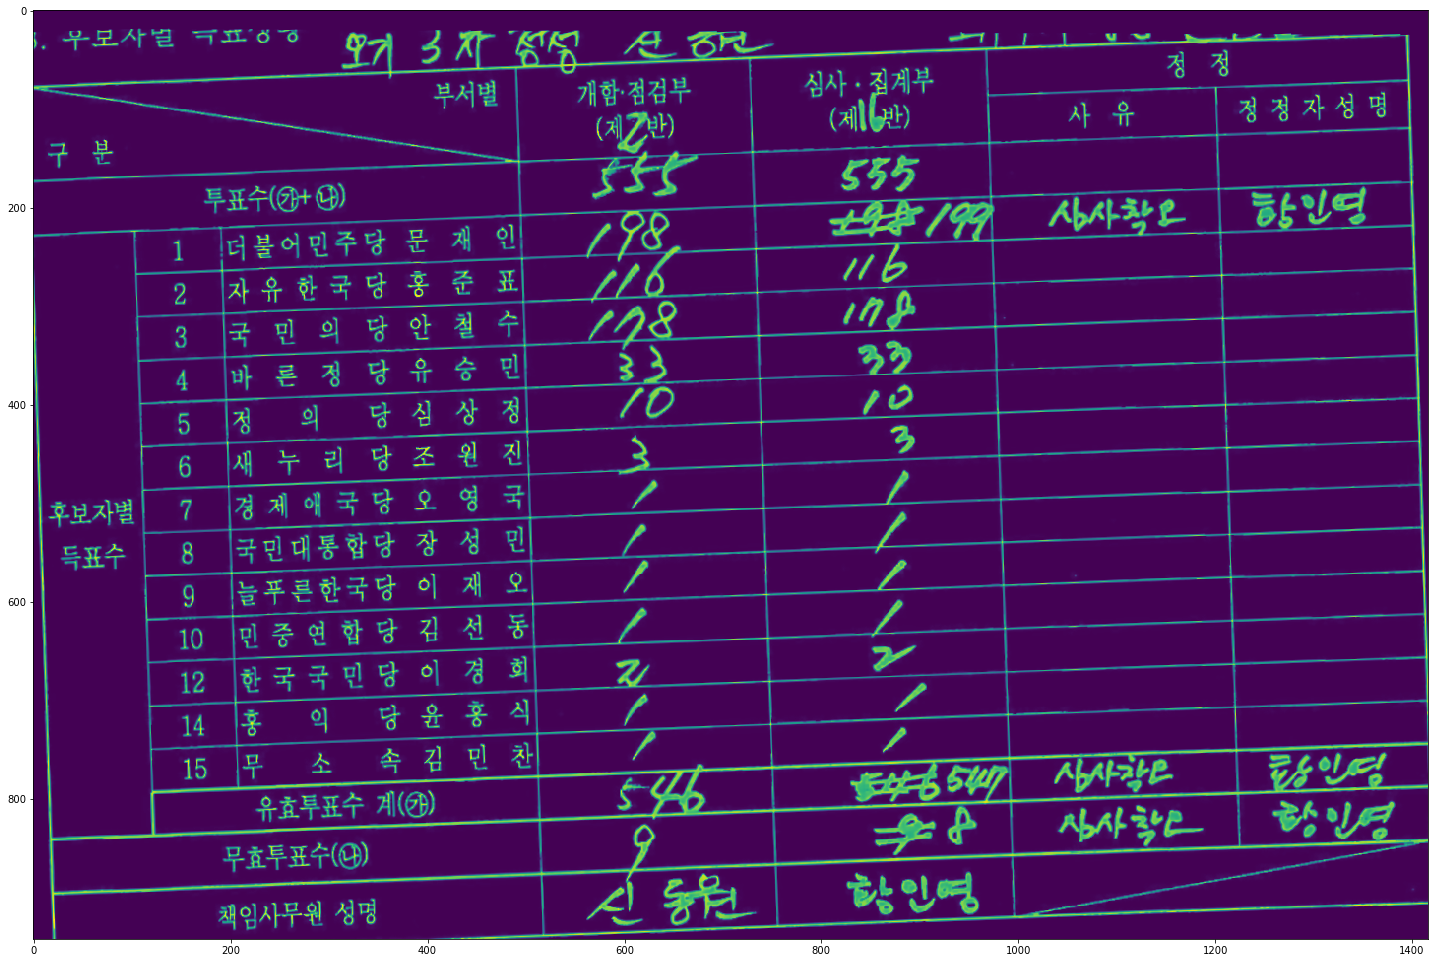

In [815]:
# testimg = load_img(200, 59, True)
# testimg = load_img(190, 26, True)
# testimg = load_img(206, 10, True)
testimg = load_img(206, 1, True)
# tgray = crop_gray_table(testimg)
# imshow(tgray)

gray = gray_img(testimg)
otsu, otsuret = gray2bin(gray)
otsu, deg = rotate_straight(otsu)
gray = rotate_img(gray, deg)
otsu, otsuret = gray2bin(gray)
gray, otsu = clear_stroke_between_tables(gray, otsu)
_, contours, hierarchy = get_contours(otsu)
h, w = otsu.shape
outline_inds = get_outline_inds(contours, hierarchy, h*w//100, trgParent=-1)
table_inds, table_bnds = split_tables(contours, outline_inds)
if not len(table_bnds): print('split error')
tx, ty, tw, th = table_bnds[1 if len(table_bnds)>1 and table_bnds[1][0] - table_bnds[0][0] > w//3 else 0]
print('tw', tw, 'h', h)
otsu, _ = gray2bin(gray, 30)
tgray, totsu = map(lambda v: v[ty-margin:ty+th+margin, tx-margin:tx+tw+margin], (gray, otsu))
# imshow(tgray)
tgray, totsu = clear_around_table(tgray, totsu, True)
totsu, deg = rotate_straight3(totsu)
tgray = rotate_img(tgray, deg)
imshow(tgray)


In [1163]:
# imshow(crop_gray_table(testimg.copy()))
    
def calc_list_sparsion(l, ind, min_sparse):
    diff = [l[i+1][ind] - l[i][ind] for i in range(len(l)-1)]
    return list(filter(lambda v:v>min_sparse, diff)), diff

def calc_im_sparsion(im, is_vertical, min_sparse, xfn, yfn, mm, mx, my, rng=None):
    if rng is None: rng = range(im.shape[0 if is_vertical else 1])
    elif type(rng) is tuple: rng = range(*rng)
    fn = xfn if is_vertical else yfn
    r = [(y, fn(y, mm, mx, my)) for y in rng] if is_vertical else [(fn(x, mm, mx, my), x) for x in rng]
    r = list(filter(lambda v : im[v[0],v[1]], r))
    return calc_list_sparsion(r, 0 if is_vertical else 1, min_sparse)

def calc_im_vertical_sparsion(im, min_sparse=1, xfn=None, mm=0, mx=0, my=0, yrng=None):
    if not xfn: xfn=lambda y, m, mx, my: mx
    return calc_im_sparsion(im, True, min_sparse, xfn, None, mm, mx, my, yrng)

def calc_im_horizontal_sparsion(im, min_sparse=1, yfn=None, mm=0, mx=0, my=0, xrng=None):
    if not yfn: yfn=lambda x, m, mx, my: my
    return calc_im_sparsion(im, False, min_sparse, None, yfn, mm, mx, my, xrng)

def calc_range_row(im, y):
    f = np.where(im[y])[0]
    if not f.any(): return
    return min(f), max(f)

rst = None
def clear_stroke_between_tables(im, otsu, dbg=False): # enhances table_split
    global rst
    im = im.copy()
    oim = otsu.copy()
    h, w = oim.shape
    oim, (ys, ye, xs, xe) = clear_blank_edges(oim[h//50:h-h//50, w//50:w-w//50])
    ys += h//50
    ye += h//50
    xs += w//50
    xe += w//50
    if dbg: print('ys=', ys, 'xs=', xs)
    lasti = 0
    lastii = 0
    lastc = 0
    
    h, w = oim.shape
    
#         if c > w//100 or maxf-minf > w//100:
#             if dbg:print(i, ':', lastc-c, '/', maxf-minf)
#             krs = i
#         elif 0 < maxf-minf < w//100 and c < w//20:
#             if dbg: print(i, 'f:', maxf-minf, '/', w//100, 'c:', c,'/', w//20)
#             oim[krs:i, :] //= 2
#             im[ys+krs:ys+i, :] = 0
        
#         c = np.count_nonzero(oim[i-h*1.7//1000:i])/(h*1.7//1000)
#         minf, maxf = w, 0
# #         for j in range(10):
# #             f = np.where(oim[i-j])[0]
# #             if len(f):
# #                 if minf>min(f):minf=min(f)
# #                 if maxf<max(f):maxf=max(f)
#         f = np.where(oim[i])[0]
#         if f.any():
#             minf, maxf = min(f), max(f)
#             lastc = np.count_nonzero(oim[i-1])
#             if w/4 + lastc < c:
#                 if dbg:print(i, ':', lastc-c, '/', maxf-minf)
#                 if lasti < i-h*1.7//1000:
#                     lasti = i
#                 else:
#                     lasti = lastii = i
#     #             if 0 < maxf-minf < w/200 and lasti > i-h*1.7/100 :
#     #                 oim[i, :] = 100
#     #                 im[ys+lasti:ys+i, :] = 0
#     #             lasti = i
#             elif 0 < lasti < i-h*1.7//100 and 0 < maxf-minf < w//100 and c < w//20:
#                 if dbg:print(lasti, '-', i, minf, maxf, maxf-minf, w/200)
#     #             for j in range(i, lasti, -1):
# #                 if lasti < i-h*1.7//100:
# #                     lasti = i
# #                 else:
#                 oim[lasti:i, :] = 100
#                 im[ys+lasti:ys+i, :] = 0
#         lastc = c
#         if c > w*10/4 and maxf-minf>w/2:
#             lasti = i
# #             if dbg: print(i)
#         elif 0 < c < w*10/100:
#             if i-h/500 < lasti:
# #                 if dbg: print(i, lasti, c)
# #             if lasti == i-1:
# #                 lastii = i
# #                 print(i, np.count_nonzero(oim[i-1]), c)
# #             elif lasti == i-2 and lastii == i-1:
# #                 oim[i, :] = 50
#                 for j in range(1, h-i):
#                     cc = np.count_nonzero(oim[i+j])
#                     if not cc or cc> c*1.5+w/2500: break
                    
#                     f = np.where(oim[i+j])[0]
                    
#                     if dbg: print(i+j, min(f), max(f), max(f)-min(f))
#                     if max(f) - min(f) > w*2/5: break
                    
#                     oim[i+j, :] = 100
#                     im[ys+i+j, :] = 0
#     lasti = 0
#     lastii = 0
#     k = h*6//12 + h//24
    
#     print(k, kh, i, h)
#     counts = []
#     lastc = np.count_nonzero(oim[k:ke,ws])
    oim2 = oim.copy()
    ####### clear whole horizontal area between tables
    ycs = 0
#     ycw = w
    lastwides = [False]*5#(h//200)
    lastsparses = [False]*5#(h//200)
    for y in range(0, h//2):
        r = calc_range_row(oim2, y)
        if not r: continue
        minf, maxf = r
        wide = maxf-minf > w*0.9
        lastwide = not False in lastwides
        sparsion = calc_im_horizontal_sparsion(oim2, w/100, my=y, xrng=range(minf, maxf))[0]
        sparsed = len(sparsion)>5
#         sparsed = sparsion and min(sparsion) > 2
        lastsparsed = not False in lastsparses
#         if y==510:oim[y:y+5,:]=200
        if dbg and 520<y<540:
            print(y, ':lastwide, wide, lastsparsed, sparsed = ', lastwide, wide, lastsparsed, sparsed, 'sparsion=', sparsion)
        if not lastwide and wide and not sparsed:
            if dbg: print(y, ':lastwide, wide, lastsparsed, sparsed = ', lastwide, wide, lastsparsed, sparsed, 'sparsion=', sparsion)
#             if dbg: print('sparsion on ', y, ':', sparsed)
#             if lastsparsed:
            if dbg: print('clearing on ',y)
#             oim[ycs:y-h//150, :] = 30
            oim[ycs:y-h//150, :] //= 2
            otsu[ys+ycs:ys+y-h//150, :] = im[ys+ycs:ys+y-h//150, :] = 0
        elif lastwide and not wide and not lastsparsed:
            if dbg: print(y, ':lastwide, wide, lastsparsed, sparsed = ', lastwide, wide, lastsparsed, sparsed)
            if dbg: print('setting ycs on ',y)
            ycs = y+h//150
        lastwides.append( wide )
        lastwides.pop(0)
        lastsparses.append( sparsed )
        lastsparses.pop(0)
    
    ####### clear horizontal blank between tables
    lastc=0
    lastsparsion=0
    for i in range(h//10, h*8//10):
        r = calc_range_row(oim, i)
        if not r: continue
        minf, maxf = r
        c = np.count_nonzero(oim2[i])
#         sparsion = calc_im_horizontal_sparsion(oim, w/200, my=i)[0]
        #if 0 < c and 0 < maxf-minf < w*4/5 and sparsion and max(sparsion)>w/10:
        if 0 < c < w/20 and 0 < maxf-minf < w/3.6:
#             rst, xfn, yfn = angular_count(oim, -2, 2, i, (0, w))
#             if max(rst, key=lambda v:v[-1])[-1] < w/10:
            if dbg:
                print('clearing - i, c, w//100, minf, maxf, maxf-minf, w//8 :', i, c, w//100, minf, maxf, maxf-minf, w//8)
#                 print('sparsion:', sparsion)
                oim[i, :] = 65
            otsu[ys+i, :] = im[ys+i, :] = 0
    if dbg: imshow(oim)
#     krs = kre
#     for i in range(kre, min(kre+h//10, h)):
#         f = np.where(oim[i])[0]
# #         if dbg:print(i, '- c:', c, 'f:', maxf-minf)
#         if not f.any(): continue
#         minf, maxf = min(f), max(f)
#         c = np.count_nonzero(oim[i])
#         if c > w//100 or maxf-minf > w//100:
#             if dbg:print(i, ':', lastc-c, '/', maxf-minf)
#             krs = i
#         elif 0 < maxf-minf < w//50 and c < w//3:
#             if dbg: print(i, 'f:', maxf-minf, '/', w//100, 'c:', c,'/', w//20)
#             if dbg:oim[krs:i, :] = 100
#             im[ys+krs:ys+i, :] = 0

    k = h*13//20
    for y in range(k+1, h):
        if np.count_nonzero(oim2[y, :]) < w/130: break
    if dbg: print('y=', y)
    ws = w*9//20
    we = w*21//40
    
    for i in range(y, k, -1):
        if oim2[i, ws]: break
    kle = i
    if dbg: print('kle=', i)
    kh = kle - k
    
    for i in range(y, k, -1):
        if np.count_nonzero(oim2[i, we:w-h//20]): break
    kre = i
    if dbg: print('kre=', i)
    krh = kre - k
    
    ####### clear vertical blank between two tables
#     print(list(filter(lambda v:v[-1] == c, rst)))

#     cs, ce = 0, 0
#     for i in range(ws, we):
# #         c = np.count_nonzero(oim[y:ye,i])
# #             print(y, '-', ye, ',', i, ':', c, '/', (kle-y) if ye == kle else h//20)
# #         if c == h//20 or (ye==kle and c == kle-y):
#         c = np.count_nonzero(oim[k:kle,i])
#         print(c, '/', kh)
#         if c == kh:
#             if not cs or cs == i:cs = i+1
#             else:
#                 ce = i-1
#                 print(k, kre, cs, ce)
#                 oim[k:kre, cs:ce] = 100
#                 im[ys+k:ys+k+kre, xs+cs:xs+ce] = 0
# #                 oim[y:ye, cs:ce] = 100
# #                 im[ys+y:ys+ye, xs+cs:xs+ce] = 0
#                 break
#     imshow(oim[kre-h//30:kre])
#     rst, xfn, yfn = angular_count(oim[h//4:kre], 90-5, 90+5, (None, None), (ws, we), True)
#     print(h//4, h//30, h//4-h//30+(kre-h//4)%(h//30))
#     for y in range(h//4-h//30+(kre-h//4)%(h//30)-1, kre, h//30):
#         ye = min(y+h//30, kle)
    cs, ce = 0, 0
    y=h//4
    ye=kre
#     rst, xfn, yfn = angular_count(oim[h//4:kre], 90-5, 90+5, (None, None), (ws, we), True)
#     rst, xfn, yfn = angular_count(oim[kre-h//30:kre], 90-5, 90+5, (None, None), (ws, we), True)
    cntim = oim2[y:ye]
    rst, xfn, yfn = angular_count(cntim, 90-5, 90+5, None, (ws, we))
    mx, my, mm, md, mc = max(rst, key=lambda v:v[-1])
    rst, xfn, yfn = angular_count(cntim, md-1, md+1, my, (mx, mx+3), .01)
    if dbg:
        for r in rst:
            print(r)
        x = mx
    mx, my, mm, md, mc = max(rst, key=lambda v:v[-1])
    if dbg:
        print('from mx:', mx-x)
    rst = list(filter(lambda v:v[0]==mx, rst))
    rst = np.array(list(filter(lambda v:v[-1]==mc, rst)))
    mm, md = map(np.median, (rst[:,2], rst[:,3]))
    if dbg:
        for r in rst:
            print(r)
        print('mx, my, mm, md, mc :', mx, my, mm, md, mc)
    sparsion = len(calc_im_vertical_sparsion(cntim, h/200, xfn, mm, mx, my, range(ye-y))[0])
    if dbg: print('sparsion test1 - sparsion=', sparsion, 'h/200=', h/200)
#     if dbg: print('sparsion test1 - max:', max(r), 'len(v>h/150):', len(list(filter(lambda v:v>h/150, r))), 'h/150=', h/150)
#     if max(r)>h/50:return im, oim
    if sparsion > 8:return im, otsu
#         imshow(cntim)
    rst, xfn, yfn = angular_count(cntim, md, md, my, (ws, we))
#     mx, my, mm, md, mc = max(rst, key=lambda v:v[-1])
#     rst = list(filter(lambda v:v[-2]==mm, rst)) # same angle
    rst = list(filter(lambda v:v[-1]>(ye-y)*0.4, rst)) # almost center of two table lines
    if dbg:
        print('continuous sparsion test')
        for i in range(len(rst)-1, 0, -1):
            sparsion = len(calc_im_vertical_sparsion(cntim, h/200, xfn, mm, rst[i][0], my, range(ye-y))[0])
            print('i, sparsion=', i, sparsion)
    last_sparsion = 0
    for i in range(len(rst)-1, 0, -1):
        sparsion = len(calc_im_vertical_sparsion(cntim, h/200, xfn, mm, rst[i][0], my, range(ye-y))[0])
        if sparsion < 10 and last_sparsion > 10:
            rst=rst[:i+1]
            break
        last_sparsion = sparsion
#     rst = list(filter(lambda v:calc_im_vertical_sparsion(cntim, xfn, mm, v[0], my, range(ye-y), h/150)))
    if dbg:
        for r in rst:
            print(r)
#     if len(rst) >10: # needs vertical clear
#     if dbg:
#         for r in rst:
#             print(r)
    if len(rst)<2: return im, otsu
    r = [rst[i+1][0] - rst[i][0] for i in range(len(rst)-1)]
    if dbg:
        imshow(cntim)
        print('max space, w/100 =', max(r), w/100)
    if max(r) < w/100: return im, otsu
    r = r.index(max(r))
    cs = rst[r][0]
    ce = rst[r+1][0]
    mx = np.median([cs, ce])
    if dbg:
        print('mx:', mx, 'r:', r, 'cs:', cs, 'ce:',ce)
    x, _, _, _, _ = max(rst[:r+1], key=lambda v:v[-1])
    sparsion = len(calc_im_vertical_sparsion(cntim, h/200, xfn, mm, x, my, range(ye-y))[0])
    if dbg: print('sparsion test2 - sparsion=', sparsion, 'h/200=', h/200)
#     if dbg: print('sparsion test2 - max:', max(r), 'len(v>h/100):', len(list(filter(lambda v:v>h/150, r))), 'h/100=', h/150)
#         print(r)
    if sparsion > 8 : return im, otsu
#     rst = sorted(rst, key=lambda v:v[-1], reverse=True)
#     if not len(rst) : return im, oim
#     mx = np.median(np.array(rst)[:, 0]) # center of table line is also the center of blank
# #     print(m)
#     ls = list(filter(lambda v:v[0]<mx, rst)) #left table line
#     if len(ls):
#         cs= min(ls, key=lambda v : abs(v[0]-mx))[0] # clear start
#     le  = list(filter(lambda v:v[0]>mx, rst)) #right table line
#     if len(le):
#         ce = min(le, key=lambda v : abs(v[0]-mx))[0] # clear end
    
    if dbg: print('mx, cs, ce, ce-cs, w//200 :', mx, cs, ce, ce-cs, w//200)
    
    if cs and ce and  ce-cs > w//200:
        mgn = w//300
        x0, x1, x2, x3 = list(map(lambda y, mx:xfn(y, mm, mx, my), (0,ye-y,ye-y,0), (cs+mgn, cs+mgn, ce-mgn, ce-mgn)))
        cv2.fillPoly(im, np.array([[(x0+xs, y+ys), (x1+xs, ye+ys), (x2+xs, ye+ys), (x3+xs, y+ys)]]).astype('int32'), 0)
        cv2.fillPoly(otsu, np.array([[(x0+xs, y+ys), (x1+xs, ye+ys), (x2+xs, ye+ys), (x3+xs, y+ys)]]).astype('int32'), 0)
        cv2.fillPoly(oim, np.array([[(x0, y), (x1, ye), (x2, ye), (x3, y)]]).astype('int32'), 100)
    
#     if dbg:
#         oim = imwin(oim, ((k, ws), (kle, ce)))
#         elif c == 0:
#             ce = i
#             break
#     cs = ws+counts.index(max(counts))
#     ce = ws+counts.index(min(counts))
#     if dbg:
#         print(counts)
#         print(cs, ce)    
#         if np.count_nonzero(oim[k:k+h//20,i]) >= h/600:
#             lasti = i
#         else:
#             c = np.count_nonzero(oim[k:k+h//12, i])
# #                 print(i, np.count_nonzero(oim[i-1]), c)
#             if c < w/100:
#                 if lasti == i-1:
#                     lastii = i
#                 elif lasti == i-2 and lastii == i-1:
#                     for j in range(w-i):
#                         if np.count_nonzero(oim[k:k+h//12, i+j])> c*2+w/250: break
#                         oim[k:k+h//12, i+j] = 100
#                         im[ys+k:ys+k+h//12, xs+i+j] = 0

#     oim = imwin(oim, ((k, w*9//20), (i, w*11//20)))
#     oim = imwin(oim, ((k, ws), (kle, ce)))
#     if cs and ce:
#         if dbg:
#             oim = imwin(oim, ((k, cs), (kle, ce)))
    if dbg:
        print('ws, we = ', ws, we)
        oim[:,ws:ws+5] = oim[:, we:we+5] = 255
#         print(cs, ce)
#         oim[:, ws:we] = 100
        imshow(oim)
#         imshow(oim[h//4:])
#         imshow(oim[h//4:kre+h//100])
#         imshow(oim[kre-h//30:kre])
    return im, otsu

# gray = gray_img(testimg)
# gray = noise_reduce(gray)
# imshow(clear_stroke_between_tables(gray))

# imshow(l[0])
# imshow(im[-170:-130,-812:-800])
# print(im[-170:-130,-812:-800])

ys= 73 xs= 58
116 :lastwide, wide, lastsparsed, sparsed =  True False False False
setting ycs on  116
145 :lastwide, wide, lastsparsed, sparsed =  True False False False
setting ycs on  145
185 :lastwide, wide, lastsparsed, sparsed =  False True False False sparsion= [14]
clearing on  185
186 :lastwide, wide, lastsparsed, sparsed =  False True False False sparsion= [36, 11, 13, 25, 122]
clearing on  186
306 :lastwide, wide, lastsparsed, sparsed =  True False False False
setting ycs on  306
356 :lastwide, wide, lastsparsed, sparsed =  False True False False sparsion= [14]
clearing on  356
357 :lastwide, wide, lastsparsed, sparsed =  False True False False sparsion= [14, 159]
clearing on  357
359 :lastwide, wide, lastsparsed, sparsed =  False True False False sparsion= [407, 95, 14, 324, 176]
clearing on  359
360 :lastwide, wide, lastsparsed, sparsed =  False True False False sparsion= [407, 95, 14, 324, 177]
clearing on  360
521 :lastwide, wide, lastsparsed, sparsed =  True True True Tr

continuous sparsion test
i, sparsion= 7 10
i, sparsion= 6 2
i, sparsion= 5 0
i, sparsion= 4 1
i, sparsion= 3 0
i, sparsion= 2 0
i, sparsion= 1 0
[518, 351, -113371591279906.55, 90.000000000000512, 396]
[519, 351, -113371591279906.55, 90.000000000000512, 699]
[520, 351, -113371591279906.55, 90.000000000000512, 699]
[521, 351, -113371591279906.55, 90.000000000000512, 341]
[534, 351, -113371591279906.55, 90.000000000000512, 408]
[535, 351, -113371591279906.55, 90.000000000000512, 702]
[536, 351, -113371591279906.55, 90.000000000000512, 648]
[537, 351, -113371591279906.55, 90.000000000000512, 310]
max space, w/100 = 13 10.95
mx: 527.5 r: 3 cs: 521 ce: 534
sparsion test2 - sparsion= 0 h/200= 7.46
mx, cs, ce, ce-cs, w//200 : 527.5 521 534 13 5
ws, we =  492 574


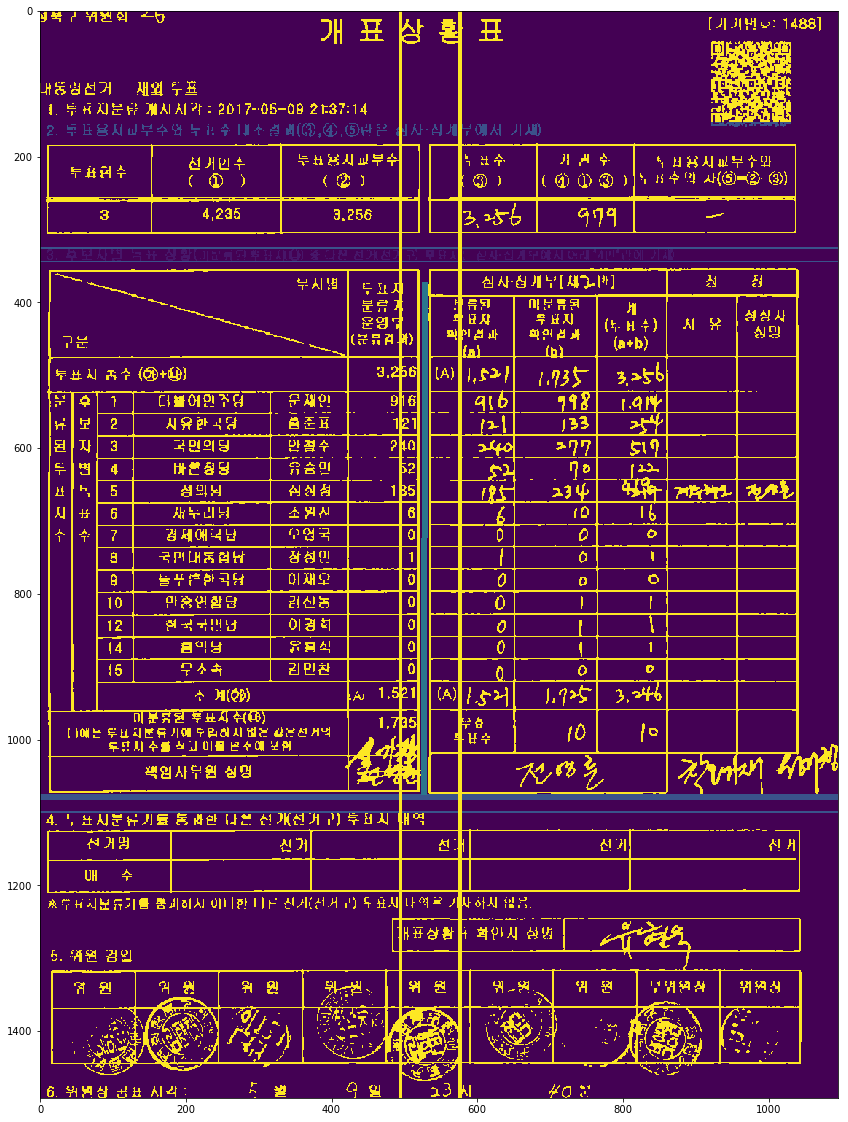

In [1165]:
testimg = load_img(218, 2, True)
#### special cases
# 0, 4  # stroke outside table of all top, right, bottom
# 17, 29
# 22, 3 # 
# 10, 17 # very thin table borders
# 49, 4, 44, 61, 62, 65, 67, 68, 76, 78 # vertical blank on table
# 53, 15 # vertical and horizontal blank
# 218, 1 # hard to clear stroke between table

# tgray = crop_gray_table(testimg)
# imshow(tgray)

gray = gray_img(testimg)
h, w = gray.shape

otsu, otsuret = gray2bin(gray)
otsu, deg = rotate_straight(otsu)
# print(deg)
h, w = otsu.shape

imshow(otsu)
gray = rotate_img(gray, deg)
otsu, otsuret = gray2bin(gray)

# t = otsu.copy()
# gray, otsu = fill_vertical_gap(gray, otsu, find_strategy=2)
# gray, otsu = fill_vertical_gap(gray, otsu, dbg=True, find_strategy=2)
# r = find_vertical_gap2(t, True)
# print(r)
# xfn, mx, my, mm, md , mc = r

# imshow(imdiv(t, 4, 2, 4, 3))
# imshow(otsu)
# imshow(imdiv(gray, 4, 2, 4, 3))
# imshow(gray)
gray, otsu = clear_stroke_between_tables(gray, otsu, True)
# gray, otsu = clear_stroke_between_tables(gray, otsu)
# imshow(gray)
# _, contours, hierarchy = get_contours(otsu)
# h, w = otsu.shape
# outline_inds = get_outline_inds(contours, hierarchy, h*w//100, trgParent=-1)
# table_inds, table_bnds = split_tables(contours, outline_inds)
# if not len(table_bnds): print('split error')
# tx, ty, tw, th = table_bnds[1 if len(table_bnds)>1 and table_bnds[1][0] - table_bnds[0][0] > w//3 else 0]
# print('tw', tw, 'h', h)
# otsu, _ = gray2bin(gray, 30)
# tgray, totsu = map(lambda v: v[ty-margin:ty+th+margin, tx-margin:tx+tw+margin], (gray, otsu))
# imshow(tgray)
# tgray, totsu = clear_around_table(tgray, totsu, True)
# totsu, deg = rotate_straight3(totsu)
# tgray = rotate_img(tgray, deg)
# imshow(tgray)

In [594]:
def find_vertical_gap2(otsu, dbg=False):
    h, w = otsu.shape
    ys, xs = h//3, w*3//5
    oim = otsu[ys:h*2//3, xs:w-w//10]
    oh, ow = oim.shape
    rst, xfn, yfn = angular_count(oim, -0.5, 0.5, (0, oh), None, .1)
    rst = list(filter(lambda v:v[-1]>ow//2, rst))
    mx, my, mm, md, mc = max(rst[:len(rst)//4], key=lambda v:v[-1])
    if dbg:
#         for r in rst:
#             sparsion = len(calc_im_horizontal_sparsion(oim, yfn, mm, mx, my, range(ow), 1)[0])
#             print(r, sparsion)
#             oim[r[1], :] = 100
#         imshow(oim)
        print(mx, my, mm, md, mc, '/', h)
#     for x in range(w):
#         y = yfn(x, mm, mx, my)
#         if oim[y, x] :
#             oim[y, x]
    sparsion, sparsion_lst = calc_im_horizontal_sparsion(oim, 1, yfn, mm, mx, my)
    if dbg: print(sparsion)
    if len(sparsion) == 1:
#         for y, x in sparsion_lst:
#             if not oim[y, x]:
        x0 = sparsion_lst.index(sparsion[0])
        y0 = yfn(x0, mm, mx, my)
        
        mx, my, mm, md, mc = max(rst[len(rst)-len(rst)//4:], key=lambda v:v[-1])
        sparsion, sparsion_lst = calc_im_horizontal_sparsion(oim, 1, yfn, mm, mx, my)
        if len(sparsion) == 1:
            x1 = sparsion_lst.index(sparsion[0])
            y1 = yfn(x1, mm, mx, my)
            d = rad2deg(line_angle(line_slope(x0, y0, x1, y1)))
            if dbg: print('degree:', d)
            if d < 0 : d+= 180
            if dbg: print('degree:', d)
            rst, xfn, yfn = angular_count(otsu, d-0.5, d+0.5, ys+y0, xs+x0, .01)
            mx, my, mm, md, mc = min(rst, key=lambda v:v[-1])
            if dbg:
                print('x0,y0,x1,y1=', x0, y0, x1, y1)
                print('mx, my, mm, md, mc=', mx, my, mm, md, mc)
#                 otsu[:, xs+x0:xs+x0+3] = 100
#                 cv2.line(otsu, (xs+x0, ys+y0), (xs+x1, ys+y1), 100, 3)
                cv2.line(otsu, (xfn(0, mm, mx, my), 0), (xfn(h, mm, mx, my), h), 100, 3)
                print('p0=', (xfn(0, mm, mx, my), 0), 'p1=', (xfn(h, mm, mx, my), h))
#                 otsu[:,mx:mx+3] = 100
            return xfn, mx, my, mm, md, mc

def find_vertical_gap1(otsu, dbg=False):
    h, w = otsu.shape
    
    rst, xfn, yfn = angular_count(otsu, 90-1, 90+1, None, (w*3//5, w-w//10), .1)
    rst = list(filter(lambda v:v[-1]>0, rst))
    mx, my, mm, md, mc = min(rst, key=lambda v:v[-1])
    if dbg: print(mx, my, mm, md, mc, '/', h)
    rst, xfn, yfn = angular_count(otsu, md-.1, md+.1, None, mx, .01)
    mx, my, mm, md, mc = min(rst, key=lambda v:v[-1])
    if mc > h//40: return
    rst = list(filter(lambda v:v[-1]==mc, rst))
    if dbg:
        for r in rst:
            print(r)
    mm, md = list(map(lambda v : np.median(np.array(rst)[:, v]), (2, 3)))
    if dbg: print(mx, my, mm, md, mc)
    return xfn, mx, my, mm, md, mc

def fill_vertical_gap(im, otsu, width=3, find_strategy=find_vertical_gap1, dbg=False):
    t = otsu.copy()
    if type(find_strategy) is int:
        find_strategy = eval('find_vertical_gap%d'%find_strategy)
    r = find_strategy(otsu)
    if not r:return im, t
    xfn, mx, my, mm, md, mc = r
    h, w = otsu.shape
    if dbg:
        print('mx, my=', mx, my)
        cv2.line(t, (xfn(0, mm, mx, my), 0), (xfn(h, mm, mx, my), h), 100, 1)
    im = im.copy()
    for y in range(1, h-1):
        x = xfn(y, mm, mx, my)
        if t[y, x-width*4:x-width*2].all() or t[y, x+width*2:x+width*4].all():
            t[y, x-width*2:x+width*2+1] = 255
            im[y, x-width*4:x+width*2+1] = max(sum(im[y, x-width*4:x-width*2])//width, sum(im[y, x+width*2:x+width*4])//width)
    return im, t

# wrap functions above

In [915]:
table_bnds = None
gray, otsu, otsuret = None, None, None
tgray, totsu = None, None
thin, thin2 = None, None
inim = None
rects = None

margin=5

def clear_around_table(im, totsu, dbg=False):
    t= totsu.copy()
    h,w  = t.shape
#     ys, ye, xe = 0,h,w
    m0 = m1 = m2 = m3 = 0
    
#     rst, xfn, yfn = angular_count(t, -5, 5, (0, h//20), (None, None))
#     x0, y0, m, d, cnt = max(rst, key=lambda v:v[-1])
#     rst, xfn, yfn = angular_count(t, d-1, d+1, (y0, y0), (x0, x0), .01)
#     x0, y0, m, d, cnt = max(rst, key=lambda v:v[-1])
#     rst = list(filter(lambda v:v[-1] == cnt, rst))
#     m = np.median(np.array(rst)[:,2])
#     m0=m
#     for y in range(y0-1, 0, -1):
#     #     print(i, rst[i])
#     #     if rst[i][-1] - rst[i-1][-1] > w*0.5:
#         if np.count_nonzero(t[y]) < w//4:
#     #         x0, y0, m, cnt = rst[i]
#     #         t[0:y0-1, :] = 0
#     #         cv2.fillPoly(t, np.array([[(0, 0), (0, yfn(0, m, x0, y0)-1), (w-1, yfn(w-1, m, x0, y0)-1), (w-1, 0)]]).astype('int32'), 0)
#             y1, y2  = yfn(0, m, x0, y), yfn(w, m, x0, y)
#             cv2.fillPoly(t, np.array([[(0, 0), (0, y1), (w, y2), (w, 0)]]).astype('int32'), 0)
#             cv2.fillPoly(im, np.array([[(0, 0), (0, y1), (w, y2), (w, 0)]]).astype('int32'), 0)
#             ys= max(0, min(y1, y2) - margin)
#             break            
    
#     if dbg:
#         print(w-w//10)
    
#     rst, xfn, yfn = angular_count(t, 90-4, 90+4, (None, None), (w-w//8,w))
#     x0, y0, m, d, cnt = max(rst, key=lambda v:v[-1])
#     st, xfn, yfn = angular_count(t, d-1, d+1, (y0, y0), (x0, x0), .01)
#     x0, y0, m, d, cnt = max(rst, key=lambda v:v[-1])
#     rst = list(filter(lambda v:v[-1] == cnt, rst))
#     m = np.median(np.array(rst)[:,2])
    
#     m1=(m + deg90rad) if m<0 else (m - deg90rad)
#     if dbg:
#         for r in rst:
#             print(r)
#         print(x0, y0, m, cnt, m1)
#     rst = list(filter(lambda v:v[-2] == m, rst))
#     for x in range(x0, w):
#         if np.count_nonzero(t[:, x]) < h//4:
#     #         t[:, x:] = 0
#     #         print(x)
#     #         print(xfn(0, m, x0, y0))
#             x1, x2 = xfn(0, m, x, y0), xfn(h, m, x, y0)
#             cv2.fillPoly(t, np.array([[(x1, 0), (x2, h), (w, h), (w, 0)]]).astype('int32'), 0)
#             cv2.fillPoly(im, np.array([[(x1, 0), (x2, h), (w, h), (w, 0)]]).astype('int32'), 0)
#     #         cv2.fillPoly(t, np.array([[(0, 0), (0, yfn(0, m, x0, y0)-1), (w-1, yfn(w-1, m, x0, y0)-1), (w-1, 0)]]).astype('int32'), 0)
#             xe= min(w, max(x1, x2) + margin)
#             break
#     #     print(x, np.count_nonzero(totsu[:, x]), '/', h/4)
    
    def clear_outside(t, im, deg, y, x):
        is_vertical = deg>45
        is_start = (is_vertical and x[0]<w//2) or (not is_vertical and y[0]<h//2)
        if dbg: print('is_vertical:', is_vertical, 'is_start:', is_start)
        rst, xfn, yfn = angular_count(t, deg-5, deg+5, y, x)
#         rst = list(filter(lambda v:calc_im_sparsion(t, is_vertical, 1, xfn, yfn, m, x0, y0)))
#                     print('sparsion:', sparsion)
#                 if not sparsion or max(sparsion) > ((h/200) if is_vertical else (w/100)):
#                     continue
        x0, y0, m, d, cnt = max(rst, key=lambda v:v[-1])
        ye = y0 if is_vertical else (y0+1)
        xe = (x0+1) if is_vertical else x0
        rst, xfn, yfn = angular_count(t, d-1, d+1, (y0, ye), (x0, xe), .01)
        x0, y0, m, d, cnt = max(rst, key=lambda v:v[-1])
        if dbg:
            print('found line on x0, y0, m, d, cnt =', x0, y0, m, d, cnt)
        rst = list(filter((lambda v:v[0] == x0) if is_vertical else (lambda v:v[1] == y0), rst))
        rst = list(filter(lambda v:v[-1] == cnt, rst))
        
        d = np.median(np.array(rst)[:,3])
        
        ys = 0 if not is_vertical and is_start else y0
        ye = h if not is_vertical and not is_start else y0
        xs = 0 if is_vertical and is_start else x0
        xe = w if is_vertical and not is_start else x0
        
        rst, xfn, yfn = angular_count(t, d, d, (ys, ye), (xs, xe))
        if is_start: rst = list(reversed(rst))
        if dbg:
            print('ys, ye, xs, xe =', ys, ye, xs, xe)
            for r in rst:
                print(r)        
        for x0, y0, m, d, cnt in rst:
            if cnt < ((h//6) if is_vertical else (w//4)):
                if is_vertical:
                    p1, p2  = (xfn(0, m, x0, y0), 0), (xfn(h, m, x0, y0), h)
                    p0 = (0 if is_start else w, 0)
                    p3 = (0 if is_start else w, h)
                else:
                    p1, p2  = (0, yfn(0, m, x0, y0)), (w, yfn(w, m, x0, y0))
                    p0 = (0, 0 if is_start else h)
                    p3 = (w, 0 if is_start else h)
                if dbg:
                    print('blanking', p0, p1, p2, p3)
                cv2.fillPoly(t, np.array([[p0, p1, p2, p3]]).astype('int32'), 0)
                cv2.fillPoly(im, np.array([[p0, p1, p2, p3]]).astype('int32'), 0)
#                 cv2.fillPoly(t, np.array([[(xs, y1), (0, ye), (w, ye), (w, y2)]]).astype('int32'), 0)
#                 cv2.fillPoly(im, np.array([[(xs, y1), (0, ye), (w, ye), (w, y2)]]).astype('int32'), 0)
                i= 0 if is_vertical else 1
                end = (max if is_start else min)(0 if is_start else w if is_vertical else h, (min if is_start else max)(p1[i], p2[i]) + (-margin if is_start else margin))
                if dbg:
                    print('max' if is_start else 'min', '(', 0 if is_start else w if is_vertical else h, ', min' if is_start else 'max', '(', p1[i], p2[i], '))')
                    print('end=', end)
                return m, end
        return 0, 0
    #top
    m0, ycs=clear_outside(t, im, 0, (0, h//20), None)
    #right
    m1, xce=clear_outside(t, im, 90, None, (w-w//7, w))
    #down
    m2, yce=clear_outside(t, im, 0, (h-h//20, h), None)
    #left
    m3, xcs=clear_outside(t, im, 90, None, (0, w//8))
#     xs=0
    
#     for y in range(y0, h):
#     #     print(i, rst[i])
#     #     if rst[i][-1] - rst[i-1][-1] > w*0.5:
#         if np.count_nonzero(t[y]) < w//6:
#     #         x0, y0, m, cnt = rst[i]
#     #         t[0:y0-1, :] = 0
#             y1, y2  = yfn(0, m, x0, y), yfn(w, m, x0, y)
#             cv2.fillPoly(t, np.array([[(0, y1), (0, h), (w, h), (w, y2)]]).astype('int32'), 0)
#             cv2.fillPoly(im, np.array([[(0, y1), (0, h), (w, h), (w, y2)]]).astype('int32'), 0)
#     #         print(y0, m)
#             ye = min(h, max(y1, y2) + margin)
#             break

    # for i in range(1, len(rst)):
    #     if rst[i][-1] - rst[i-1][-1] > h*0.5:
    #         print(i, rst[i])
    #         x0, y0, m, cnt = rst[i]
    # #         t[0:y0-1, :] = 0
    #         cv2.fillPoly(t, np.array([[(xfn(0, m, x0, y0)+1, 0), (xfn(h, m, x0, y0)+1, h), (w, h), (w, 0)]]).astype('int32'), 0)
    # #         print(y0, m)
    #         break

    # x0, y0, m, cnt = max(rst, key=lambda v: v[-1])
    # print(y0, cnt)
    # t[0:y0-1, :] = 0
    t = t[ycs:yce, xcs:xce]
    im = im[ycs:yce, xcs:xce]
    from math import atan
    if dbg:
        print('m0, m1, m2 =', m0, m1, m2)
        print('in degrees =', *list(map(lambda v : rad2deg(atan(v)), (m0, m1, m2))))
        print('ycs, yce, xcs, xce =', ycs, yce, xcs, xce)
#     m = rad2deg(atan(sum(m0,m1,m2)/3))
#     t=img_rotate(t, m)
#     im=img_rotate(im, m)
    return im, t
    # imshow(img_rotate())

def crop_table(otsu):
    h, w = otsu.shape
    _, contours, hierarchy = get_contours(otsu)
    outline_inds = get_outline_inds(contours, hierarchy, h*w//100, trgParent=-1)
    table_inds, table_bnds = split_tables(contours, outline_inds)
    if not len(table_bnds):
        return gray
    is_normal_form = len(table_bnds)>1 and table_bnds[1][0] - table_bnds[0][0] > w//3
    tx, ty, tw, th = table_bnds[1 if is_normal_form else 0]
    return is_normal_form, tx, ty, tw, th

def crop_gray_table(im, bmrk=False, dbg=False):
    global table_bnds, gray, otsu, tgray, totsu, otsuret
    if bmrk: t=tmr()
    
    gray = gray_img(im)
    otsu, otsuret = gray2bin(gray)
    otsu, deg = rotate_straight(otsu)
    gray = rotate_img(gray, deg)
    otsu, otsuret = gray2bin(gray)
    gray, _ = clear_stroke_between_tables(gray, otsu)
    
    if dbg: imshow_now(otsu, False)
    
    h, w = otsu.shape
    
    r = crop_table(otsu)
    if len(r)==1:return r
    is_normal_form, tx, ty, tw, th = r
    
    if is_normal_form and tw < w//3:
        print('seems it has vertical gap. cropping again after filling gap')
        gray, otsu = fill_vertical_gap(gray, otsu)
        is_normal_form, tx, ty, tw, th = crop_table(otsu)
    if is_normal_form and tw < w//3:
        print('seems it still has vertical gap. cropping again after filling gap with table only filling')
        gray, otsu = fill_vertical_gap(gray, otsu, find_strategy=2)
        is_normal_form, tx, ty, tw, th = crop_table(otsu)
    if is_normal_form and tw < w//3:
        print('seems it still has vertical gap. continuing with broken table')
        
    
    otsu, _ = gray2bin(gray, 30)
    
    tgray, totsu = map(lambda v: v[ty-margin:ty+th+margin, tx-margin:tx+tw+margin], (gray, otsu))
    
    tgray, totsu = clear_around_table(tgray, totsu, dbg)
    
    totsu, deg = rotate_straight3(totsu)
    tgray = rotate_img(tgray, deg)
    
    if bmrk: print(tmr()-t, 'seconds took for totsu&tgray')
    
    return tgray

def recog_image(im):
    global otsuret, thin, thin2, intim, rects
    tgray = crop_gray_table(im)
    plt.subplot(221).imshow(tgray)
    if bmrk:t=tmr()
    thin = zhangSuen(tgray>otsuret) # faster than //255
    if bmrk:print(tmr()-t, 'seconds took to zhangSuen');
    plt.subplot(222).imshow(thin)
    t=tmr()
    thin2 = thin.copy()
    for i, r in enumerate(replace_templates):
        replace_2d_both(thin2, *r)
    print(tmr()-t, 'seconds took to replace');t=tmr()
    _, tcontours, thierarchy = get_contours(thin2)
    
    intim = thin2.copy()
    intersections, intim = find_undefect_corners(intim, tcontours)
    intersections = median_dot_group(intersections)
    
    intim //= 2
    for i in sorted(find_isolated_intersections(intersections, 0, 0), reverse=True):
        y, x = intersections.pop(i)
        intim[y, x] = 255*3//4
    for y, x in intersections:
        intim[y,x] = 255
    
    sparse_intersections = spartialize(intim)
    plt.subplot(223).imshow(intim)
    sorted_intersections = sort_sparse(sparse_intersections)
    rects = sparse_rectangle_search(sorted_intersections)
    print(tmr()-t, 'seconds took to search rects');t=tmr()
    rst = []
    for i in range(len(rects)):
        y, x = map(lambda v: np.min(np.array(rects[i])[:,v]), (0,1))
        y1, x1 = map(lambda v: np.max(np.array(rects[i])[:,v]), (0,1))
        gcell, ocell = map(lambda v: v[y-margin:y1-margin+1,x-margin:x1-margin+1].copy().astype('uint8'), (tgray, totsu))
        v, lst = recog_cell(gcell, ocell)
        rst.append(v)
    return rst
# recog_image(testimg)

ys= 101 xs= 116
501 :lastwide, wide, lastsparsed, sparsed =  True True True True sparsion= [31, 18, 24, 19, 52, 33, 21, 52, 22, 45, 21, 24, 16, 70, 38, 229, 27, 30, 52]
502 :lastwide, wide, lastsparsed, sparsed =  True True True True sparsion= [31, 63, 19, 39, 50, 23, 53, 22, 45, 21, 29, 69, 42, 229, 27, 17, 17, 51, 15]
503 :lastwide, wide, lastsparsed, sparsed =  True True True True sparsion= [44, 63, 19, 121, 56, 44, 22, 29, 67, 42, 216, 18, 27, 17, 22, 15, 50, 17]
504 :lastwide, wide, lastsparsed, sparsed =  True False True True sparsion= [65, 21, 178, 43, 22, 28, 66, 42, 217, 19, 28, 16, 22, 16, 49, 24]
505 :lastwide, wide, lastsparsed, sparsed =  False False True True sparsion= [42, 24, 34, 65, 41, 216, 20, 28, 15, 21, 47, 23, 18]
506 :lastwide, wide, lastsparsed, sparsed =  False False True True sparsion= [41, 29, 36, 64, 40, 216, 22, 28, 16, 20, 18, 46, 22, 18]
507 :lastwide, wide, lastsparsed, sparsed =  False False True True sparsion= [40, 29, 38, 63, 39, 218, 21, 28, 15, 23, 

y= 1424
kle= 1418
kre= 1417
[736, 444, 57.289961630759144, 89.0, 129]
[736, 444, 57.8687650595177, 89.010000000000005, 129]
[736, 444, 58.45937961570752, 89.02000000000001, 131]
[736, 444, 59.06217059193398, 89.030000000000015, 133]
[736, 444, 59.67751850132454, 89.04000000000002, 133]
[736, 444, 60.30581987861518, 89.050000000000026, 135]
[736, 444, 60.94748813235716, 89.060000000000031, 135]
[736, 444, 61.60295445211712, 89.070000000000036, 137]
[736, 444, 62.272668774834166, 89.080000000000041, 138]
[736, 444, 62.957100814892655, 89.090000000000046, 138]
[736, 444, 63.65674116287529, 89.100000000000051, 139]
[736, 444, 64.3721024583761, 89.110000000000056, 140]
[736, 444, 65.10372064279248, 89.120000000000061, 142]
[736, 444, 65.85215629850181, 89.130000000000067, 142]
[736, 444, 66.61799608148426, 89.140000000000072, 144]
[736, 444, 67.40185425505626, 89.150000000000077, 146]
[736, 444, 68.20437433317132, 89.160000000000082, 148]
[736, 444, 69.0262308425036, 89.170000000000087, 150

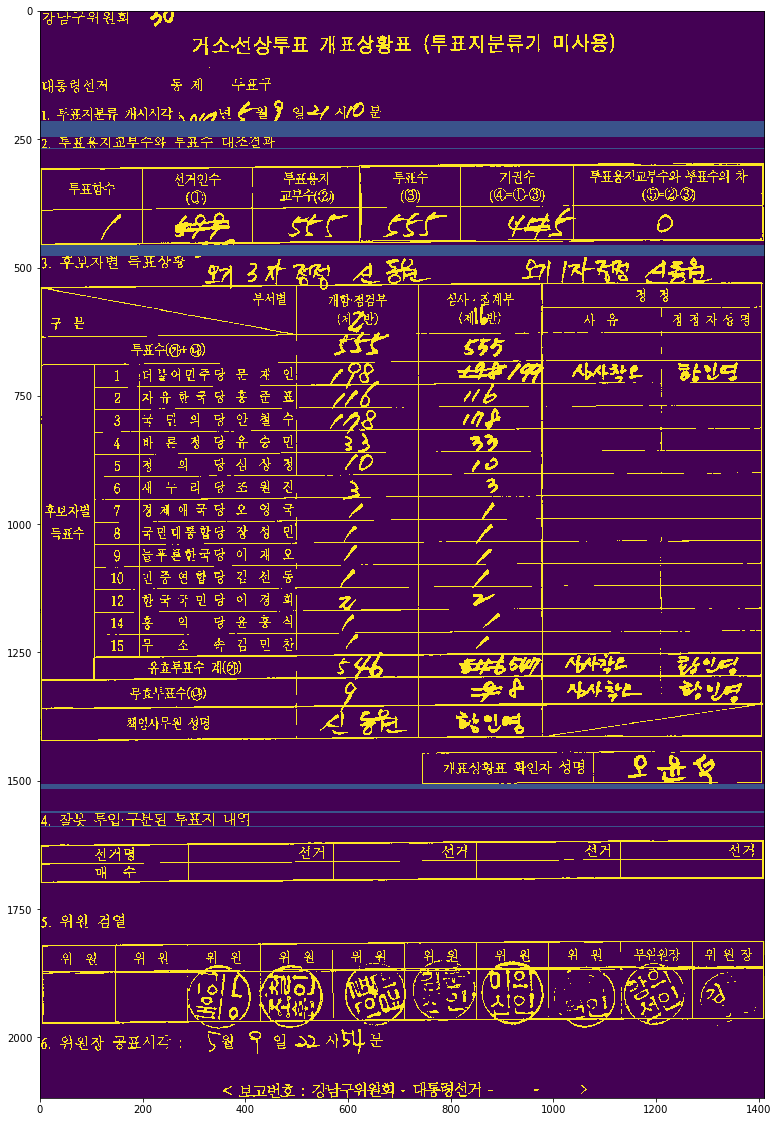

In [930]:
# testimg = load_img(200, 59, True)
# testimg = load_img(190, 26, True)
# testimg = load_img(206, 10, True)
testimg = load_img(206, 1, True)
# tgray = crop_gray_table(testimg)
# imshow(tgray)

gray = gray_img(testimg)
otsu, otsuret = gray2bin(gray)
otsu, deg = rotate_straight(otsu)
gray = rotate_img(gray, deg)
otsu, otsuret = gray2bin(gray)
gray, otsu = clear_stroke_between_tables(gray, otsu, True)
# _, contours, hierarchy = get_contours(otsu)
# h, w = otsu.shape
# outline_inds = get_outline_inds(contours, hierarchy, h*w//100, trgParent=-1)
# table_inds, table_bnds = split_tables(contours, outline_inds)
# if not len(table_bnds): print('split error')
# tx, ty, tw, th = table_bnds[1 if len(table_bnds)>1 and table_bnds[1][0] - table_bnds[0][0] > w//3 else 0]
# print('tw', tw, 'h', h)
# otsu, _ = gray2bin(gray, 30)
# tgray, totsu = map(lambda v: v[ty-margin:ty+th+margin, tx-margin:tx+tw+margin], (gray, otsu))
# # imshow(tgray)
# tgray, totsu = clear_around_table(tgray, totsu)
# totsu, deg = rotate_straight3(totsu)
# tgray = rotate_img(tgray, deg)
# imshow(tgray)


In [32]:
def write_recog(im, pagenum, outf):
    rst = ','.join([pagenum, "'"+recog_image(im).replace("'","''")+"'"])+'\n'
    print(rst)
#     imid = hashlib.md5(img.tostring()).hexdigest()
    import fileinput
    found=False
    with fileinput.FileInput(outf, inplace=True, backup='.bak') as file:
        for line in file:
            if not found and line.startswith(pagenum):
                found=True
                print(rst, end='')
            else: print(line, end='')
    if not found:
        with open(outf, 'a') as f:
            f.write(rst)
#         imshow(im)
#         locname = input('name>')

# load images from pdf files

In [33]:
from pathlib import Path
pdfdir = Path('../data/pdf')

# print(len([f.resolve(True) for f in pdfdir.glob('*/*')]))

pdf_files = [f.resolve(True) for f in pdfdir.glob('**/*.pdf')]
print(len(pdf_files), 'pdf files found')
def remove_fwith_extra_version(pdf_files, tflag):
    for f in [f.resolve(True) for f in pdfdir.glob('**/*%s.pdf' % tflag)]: # rasterized pdfs should ends with _r
        n = str(f)[:-len(tflag+'.pdf')]+'.pdf'
        i = np.argwhere(np.array([str(v) for v in pdf_files]) == n)
        if i.size:
            print(n, 'is removed because it has %s version' % tflag)
            pdf_files.pop(i[0,0])

remove_fwith_extra_version(pdf_files, '_r')
print(len(pdf_files), 'left after removing original files of raterized pdfs')

remove_fwith_extra_version(pdf_files, '_h')
print(len(pdf_files), 'left after removing original files of header pdfs')

# print(pdf_files)

366 pdf files found
/home/civiceyes/개표상황표/data/pdf/전라남도/전남 영광군.pdf is removed because it has _r version
/home/civiceyes/개표상황표/data/pdf/전라남도/전남 장흥군.pdf is removed because it has _r version
/home/civiceyes/개표상황표/data/pdf/전라남도/전남 해남군.pdf is removed because it has _r version
/home/civiceyes/개표상황표/data/pdf/전라남도/전남 신안군.pdf is removed because it has _r version
/home/civiceyes/개표상황표/data/pdf/전라남도/전남 목포시.pdf is removed because it has _r version
/home/civiceyes/개표상황표/data/pdf/전라남도/전남 영암군.pdf is removed because it has _r version
/home/civiceyes/개표상황표/data/pdf/전라남도/전남 광양시.pdf is removed because it has _r version
/home/civiceyes/개표상황표/data/pdf/충청남도/충남 보령시.pdf is removed because it has _r version
/home/civiceyes/개표상황표/data/pdf/부산광역시/부산 해운대구.pdf is removed because it has _r version
/home/civiceyes/개표상황표/data/pdf/부산광역시/부산 남구.pdf is removed because it has _r version
/home/civiceyes/개표상황표/data/pdf/강원도/강원 태백시.pdf is removed because it has _r version
/home/civiceyes/개표상황표/data/pdf/강원도/강원 원주시.pdf is remove

In [50]:
from PyPDF2 import PdfFileReader, PdfFileWriter

### working PdfObject.getData() from : https://github.com/sylvainpelissier/PyPDF2/blob/master/PyPDF2/filters.py

def pdfobj2img(obj):
    from PIL import Image
    data = obj.getData()
    if not len(data): return None
#     print(obj.get('/Filter'))
    if obj['/Filter'] == '/FlateDecode':
        size = obj['/Width'], obj['/Height']
        im = Image.frombytes('RGB', size, data)
    else:#if obj['/Filter'] == '/DCTDecode' or obj['/Filter'] == '/JPXDecode':
        from io import BytesIO
        im = Image.open(BytesIO(data))
#     else:
#         print(obj['/Filter'])
#         return None
#     im.show()
    return im

def image_from_page(f, pages, pagenum, force_portrait=True):
    xobj = pages[pagenum-1]['/Resources']['/XObject']
    pdfimages = [xobj[o] for o in xobj if xobj[o]['/Subtype'] == '/Image']
    assert len(pdfimages) == 1 # don't allow pdf files with multiple image layers
    try:
        im = pdfobj2img(pdfimages[0])
        if not im: print(f, 'has empty data')
    except:
        import subprocess
#         print(pagenum, str(f))
        sp=subprocess.run('gs -dNOPAUSE -q -sDEVICE=png16m -r600 -dBATCH -dFirstPage={0} -dLastPage={0} -o %stdout'.format(pagenum).split()+
                         [str(f.stream.name)], stdout=subprocess.PIPE)
        from io import BytesIO
        im = Image.open(BytesIO(sp.stdout))
    if force_portrait:
        w, h = im.size
        if w > h : im = im.rotate(90, expand=True)
    return im

def images_from_pdf(pdf, pagenum=None):
    f = PdfFileReader(pdf.open('rb'))
    pages = f.pages
#     if pagenum is not None : yield image_from_page(f, pages, pagenum)
    for i in range((pagenum-1) if pagenum else 0, len(pages)):
        yield i+1, image_from_page(f, pages, i+1)

def load_img(fileind=0, pagenum=1, fetchmode = False):
    rst = None
#     fetchmode = fileind is not None and pagenum is not None
    if fetchmode :
        return next(images_from_pdf(pdf_files[fileind],pagenum))[1]
    for fi, f in enumerate(pdf_files[fileind:]):
        outf = str(f)[:-4]+'.csv'
#         print('writting result of', f, 'to', outf)
    #     if fi==23:
        for n, im in images_from_pdf(f, pagenum):
    #             if n == 23:
        #                 imshow(im)
        #                 print(n, 'page of', outf)
        #                 break
        #         break
        #         input()
        #         write_recog(im, n, outf)
#                 imshow_now(im)
            im = crop_gray_table(im)
#             imshow_now(im, False)
            print('file index=', fileind+fi ,'page=', n)
            imsave(im, '%03d,%03d'%(fileind+fi, n))
            del im
        #         imshow(im)
    #             l.append(im)
        #         break
        if pagenum: pagenum = None

save_page = lambda fi, pn : imsave(crop_gray_table(load_img(fi, pn, True)), '%03d,%03d'%(fi,pn))

In [1033]:
# load_img(190, 26)
# load_img(213, 56)
# load_img(216, 54)

save_page(0, 7)

# save_page(200, 31)
# save_page(200, 59)
# save_page(200, 69)
# save_page(200, 81)
# save_page(200, 90)
# save_page(200, 99)
# save_page(200, 100)
# save_page(200, 109)

# load_img(225, 38)

######### issue case report

### vertical clear wrong

### wrong clear

### gap filling doesn't work
# 200, 31, 59, 69, 81, 90, 99, 100, 109

### horizontal clear doesn't work
# 206, 1
# 203, 53

### stroke between tables
# 55, 12, 22, 28,

### wrong rotation
# 23, 5

### need upper clean
# 94, 9
# 99, 1
# 204, 3

### need below clean
# 46, 26

### too much crop
# 212, 4

### too low quality
# 205, 3
# 224, 3

######### fixed issue
### vertical clear wrong
### wrong clear
# 204, 2, 5, 6, 7, 8
# 208, 28 (vertical noise on right blank)
# 204, 113

### gap filling
# 190, 18, 20, 26, 31, 40, 41, 49, 51, 53, 63, 69, 72, 74, 77
# 49, 4, 44, 53, 61, 62, 65, 67, 68, 76, 78
# 53, 13, 15, 22, 23, 27, 30, 33, 36, 37, 39, 41, 44, 46, 48, 49

### horizontal clear doesn't work
# 232, 17
### stroke between tables
### wrong rotation
### need upper clean
### need below clean
### too much crop
### too low quality


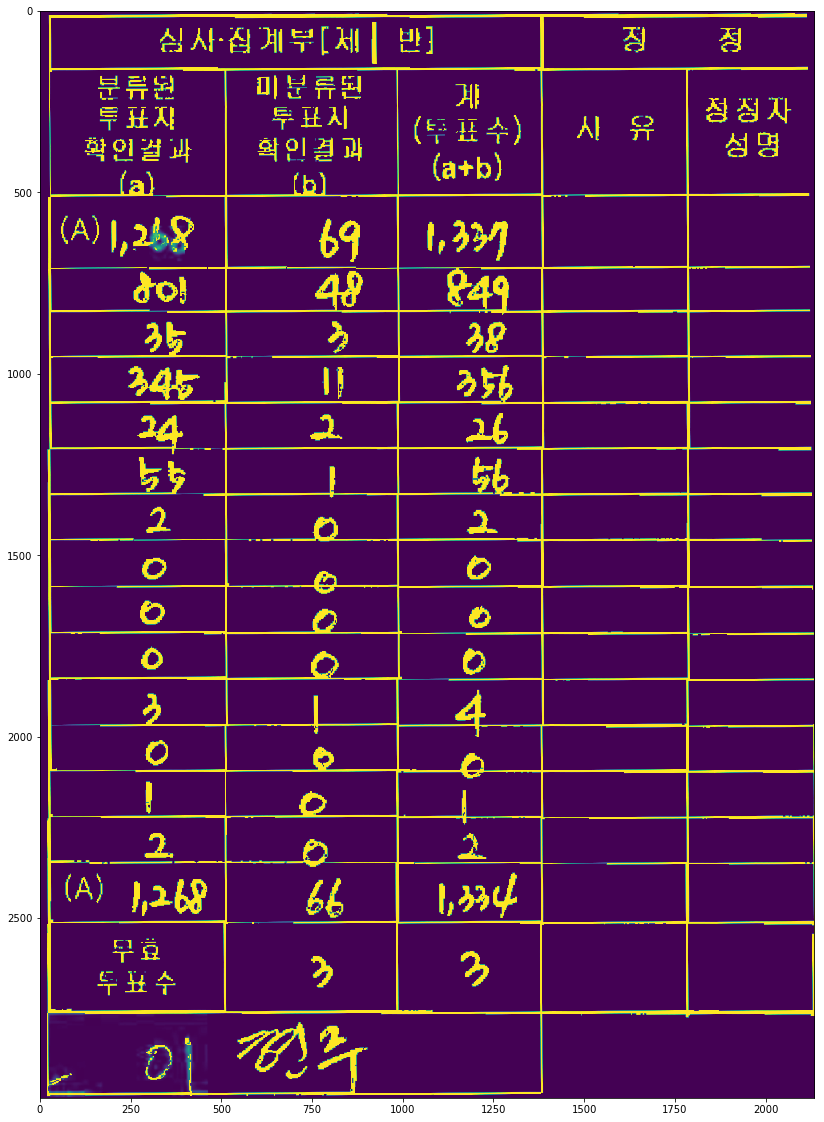

In [1029]:
# testimg = load_img(200, 59, True)
# testimg = load_img(190, 26, True)
# testimg = load_img(200, 31, True)
# testimg = load_img(204, 113, True)
# testimg = load_img(218, 47, True)

testimg = load_img(10, 17, True)

tgray = crop_gray_table(testimg)
imshow(tgray)

# gray = gray_img(testimg)

# otsu, otsuret = gray2bin(gray)
# otsu, deg = rotate_straight(otsu)
# gray = rotate_img(gray, deg)
# otsu, otsuret = gray2bin(gray)
# imshow(otsu)

# r = find_vertical_gap2(otsu.copy(), True)
# print(r)

# g, t = fill_vertical_gap(gray.copy(), otsu.copy(), 2, True)

# gray, otsu = clear_stroke_between_tables(gray, otsu, True)
# gray, otsu = clear_stroke_between_tables(gray, otsu)
# _, contours, hierarchy = get_contours(otsu)
# h, w = otsu.shape
# outline_inds = get_outline_inds(contours, hierarchy, h*w//100, trgParent=-1)
# table_inds, table_bnds = split_tables(contours, outline_inds)
# if not len(table_bnds): print('split error')
# tx, ty, tw, th = table_bnds[1 if len(table_bnds)>1 and table_bnds[1][0] - table_bnds[0][0] > w//3 else 0]
# print('tw', tw, 'h', h)
# otsu, _ = gray2bin(gray, 30)
# tgray, totsu = map(lambda v: v[ty-margin:ty+th+margin, tx-margin:tx+tw+margin], (gray, otsu))
# tgray, totsu = clear_around_table(tgray, totsu, True)
# totsu, deg = rotate_straight3(totsu)
# tgray = rotate_img(tgray, deg)
# imshow(tgray[:tgray.shape[0]//20])

# plt.subplot(121).imshow(testimg)
# plt.subplot(122).imshow(rotate_straight(otsu, True)[0])
# plt.subplot(122).imshow(t)


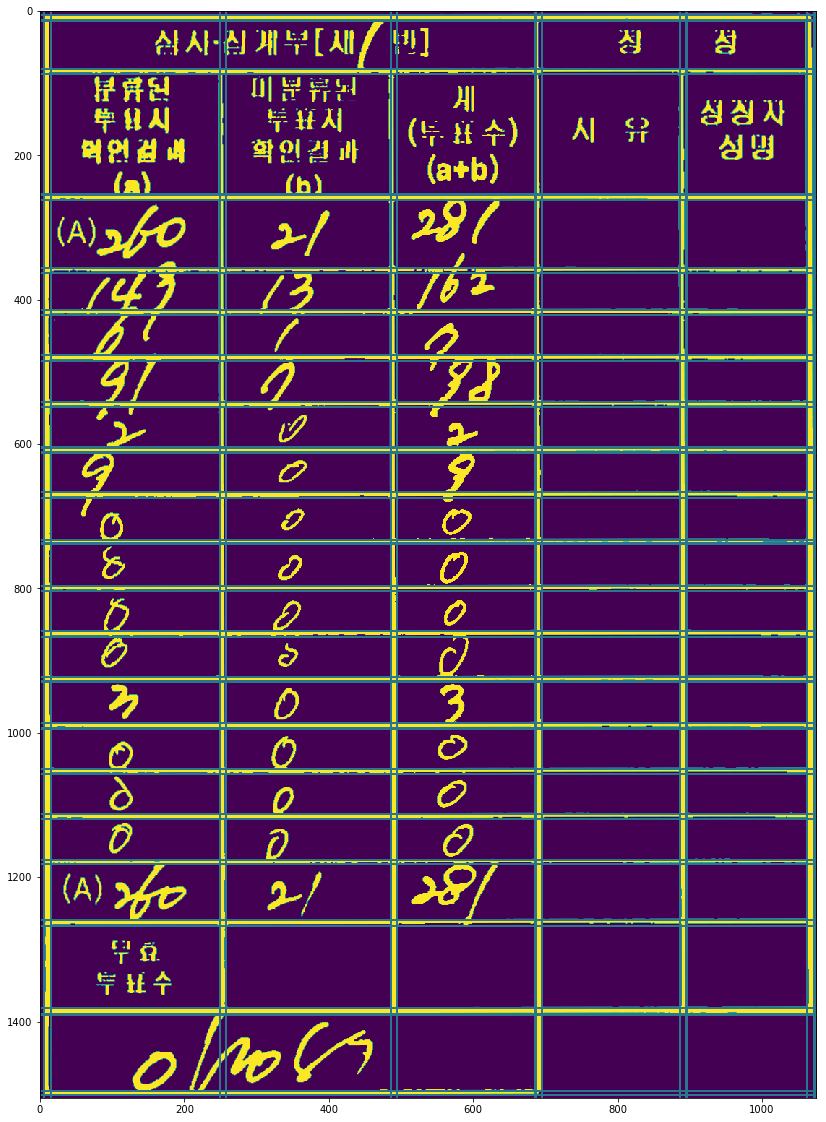

In [1166]:
rows, cols = split_cell(totsu, True)

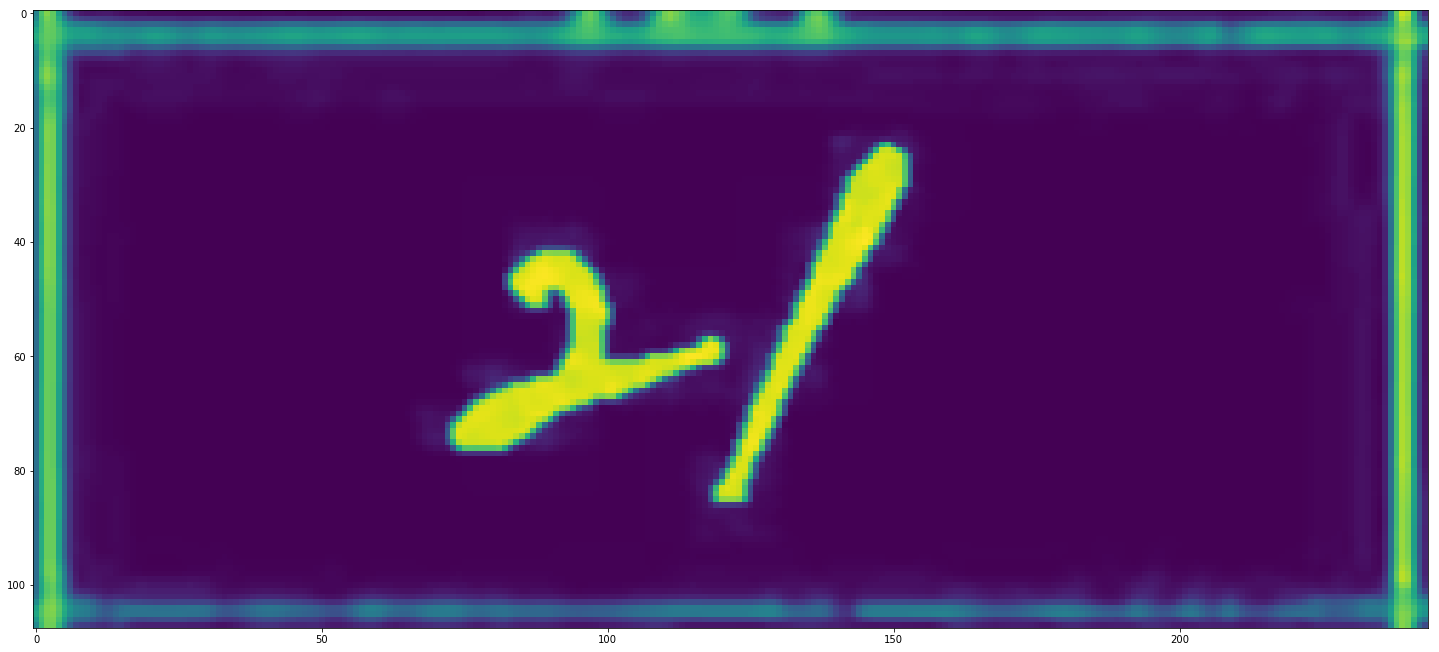

KeyboardInterrupt: 

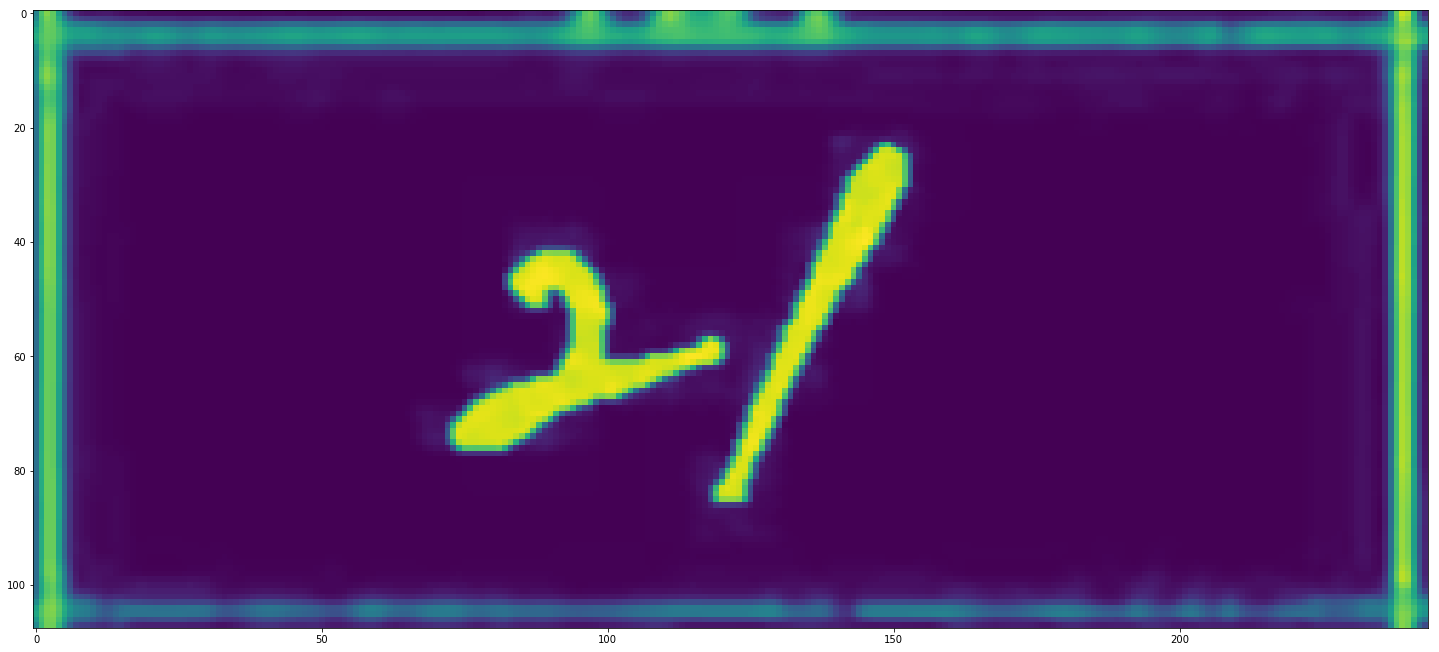

In [1263]:
for (r, c), (cim, oim) in iter_cell(tgray, totsu):
    rcg = recog_cell(cim, oim)
    imshow_now(cim, msg='%s, %s : %s'%(r, c, rcg[0]))

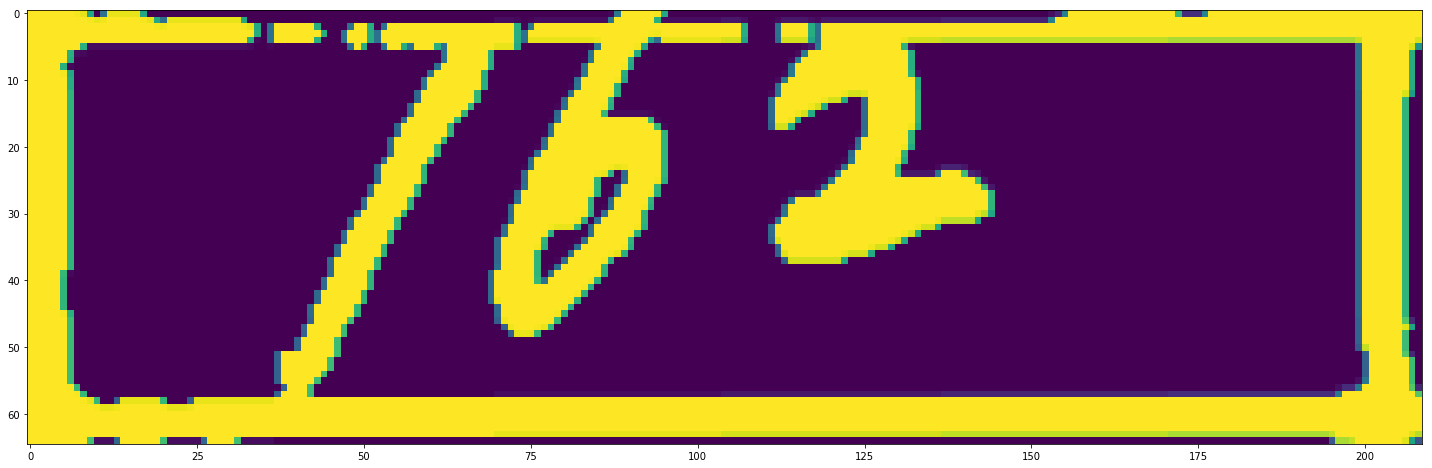

In [1270]:
cim, oim = get_cell(tgray, totsu, rows, cols, 3, 2)
imshow(oim)
# 

In [ ]:
# imshow(clear_cell_border2(oim))

ys, ye, xs, xe = clear_cell_border2(oim)
print(r)
o = oim.copy()
o[:ys, :] = o[ys+1]
o[ye:, :] = o[ye-1]
o[:, :xs] = 0
o[:, xe:] = 0

# o = stretch_clear_cell_border(oim.copy(), *r)

# stretch_clear_cell_border(recogim, *r)
imshow(o)
oim=o

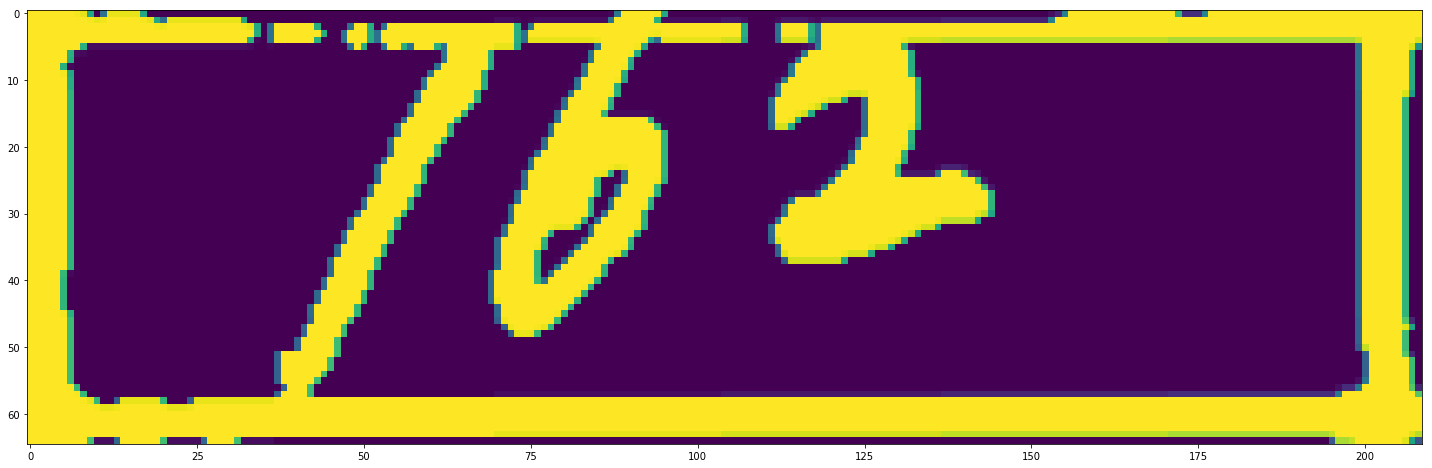

In [1273]:
imshow(oim)

error: /home/travis/miniconda/conda-bld/conda_1486587069159/work/opencv-3.1.0/modules/imgproc/src/imgwarp.cpp:3229: error: (-215) ssize.area() > 0 in function resize


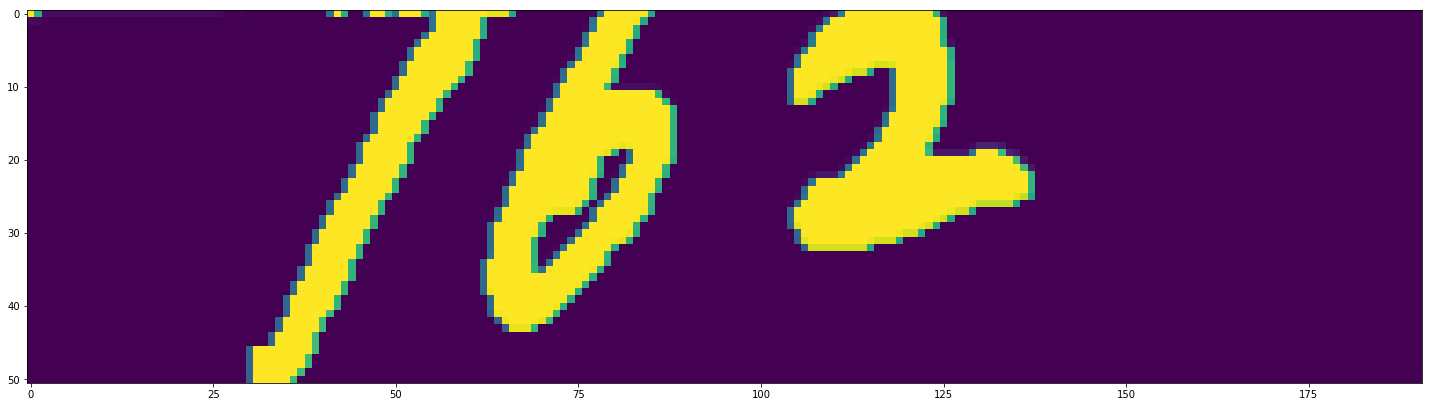

In [1276]:
# print(recog_inner_cell(cim, oim, True))
ys, ye, xs, xe = clear_cell_border2(oim)
otsuim = oim[ys:ye, xs:xe].copy()
recogim = cim[ys:ye, xs:xe].copy()
imshow(otsuim)
print(recog_inner_cell(recogim, otsuim))
# _, ccontours, chierarchy = get_contours(otsuim)
# rst = []
# bh, bw = otsuim.shape
# cellarea = bh * bw
# for c in ccontours:
#     a = cv2.contourArea(c)
#     x, y, w, h = cv2.boundingRect(c)
#     print('width:', w, '/',bw, 'height:', h, '/', bh, 'area:', a, '/', cellarea/200)
# #     imshow_now(recogim[y:y+h, x:x+w])
#     if a < cellarea/200 or h < bh/4: continue
#     if w > bw/10:
#         print((y, x, w, h, a), 'not skipped')
# #         for i in range(1,11): # up
# #             if y-i<0 or not recogim[y-i, x:x+w].any():
# #                 break
# #         for j in range(1, 11): # left
# #             if x-j<0 or not recogim[y-i:y+w, x-j].any():
# #                 break
# #         for k in range(1, 11): # down
# #             if y+h+k >= bh or not recogim[y+h+k, x-j:x+w].any():
# #                 break
# #         for l in range(1, 11): # right
# #             if x+w+l >= bw or  not recogim[y-i:y+h+k, x+w+l].any():
# #                 break
        
#         print((y-i, y+h+k, x-j, x+w+l))
#         rcg = clear_blank_edges(recogim[y:y+h, x:x+w].copy())[0].astype('uint8')
# #         rcg = clear_blank_edges(recogim[y-i-1:y+h+k+1, x-j-1:x+w+l+1].copy())[0].astype('uint8')
# #         imshow_now(rcg, True, 'not skipped')
#         r = []
#         splits = split_recog(rcg, (h//3,w//4))
#         print(len(splits), 'splits')
#         for p, im in splits:
#             print('split recognized:', p)
# #             imshow_now(im, True, p)
#             r.append([p, im])
#         if not r:
#             r1 = predict_rst(model, reshape(rcg)[0], None)
#             print('whole recog:', r1)
#             if r1 is None: dbgim= rcg
#             imshow_now(rcg, True, r1)
#             if r1: r.append([r1, rcg])
#         if r :rst.append([x, r])
# _rst = sorted(rst, key=lambda v:v[0], reverse=True)
# rst = []
# tot = 0
# i = 0
# for x, r in _rst:
#     r.reverse()
#     for p, im in r:
#         tot += p*10**i
#         i+=1
#         rst.insert(0, [p, im])
#         print(p)
# print(tot)

array([[  9.99999881e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.40257569e-07,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00]], dtype=float32)

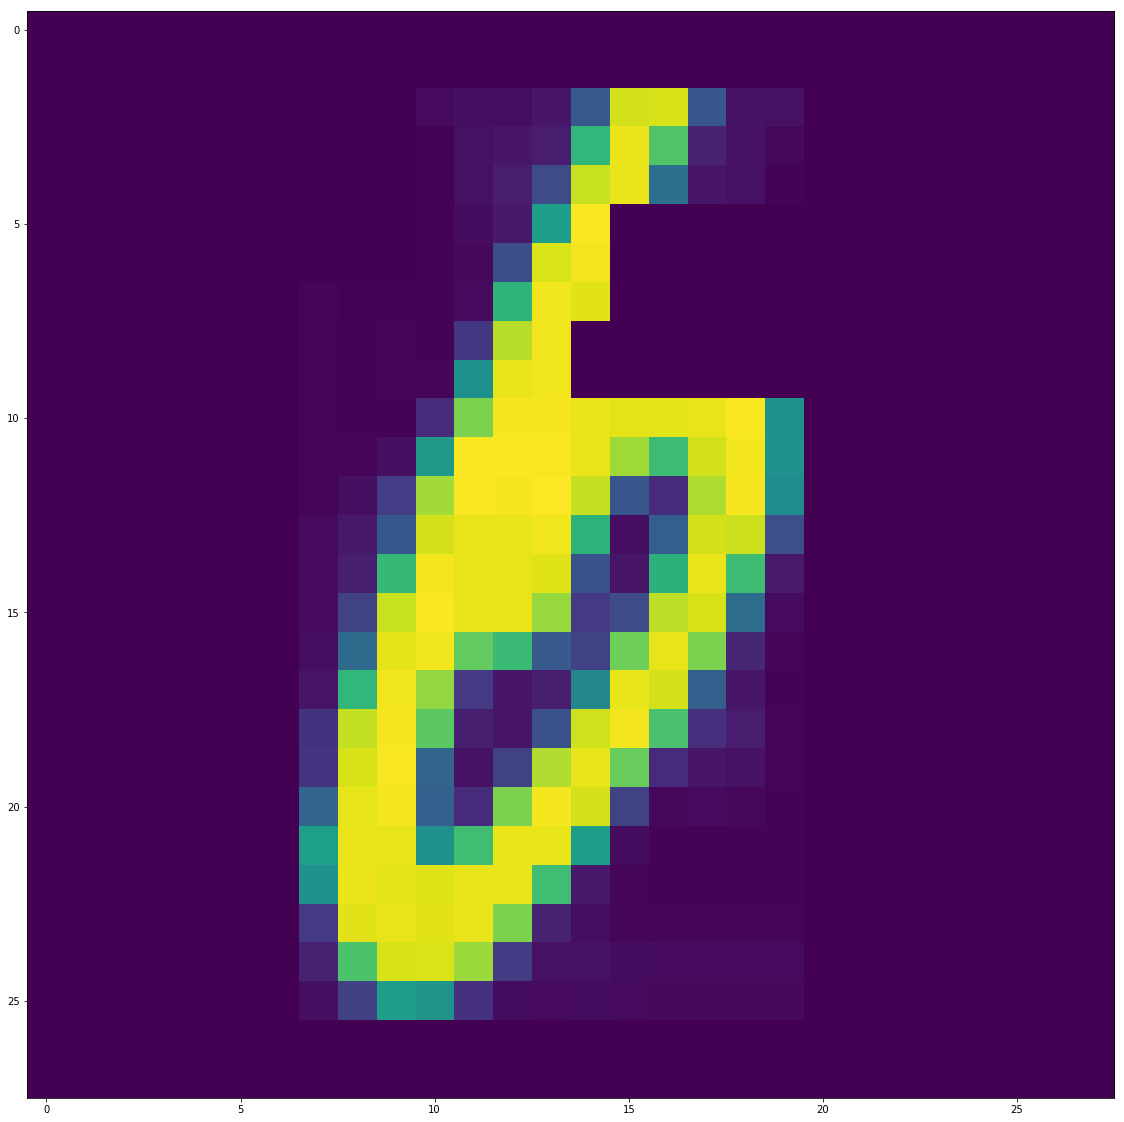

In [1238]:
# r1 = model.predict(reshape(rcg)[0])
# print(r1)
dbgim = resize_keep_ratio(rcg, (28, 28))
dbgim[0:7,0:10] = 0
dbgim[5:9,15:] = 0
dbgim[8:10,14:] = 0
imshow(dbgim)
model.predict(reshape(dbgim)[0])
# model.predict(reshape(resize_keep_ratio(rcg, (28, 28)))[0])

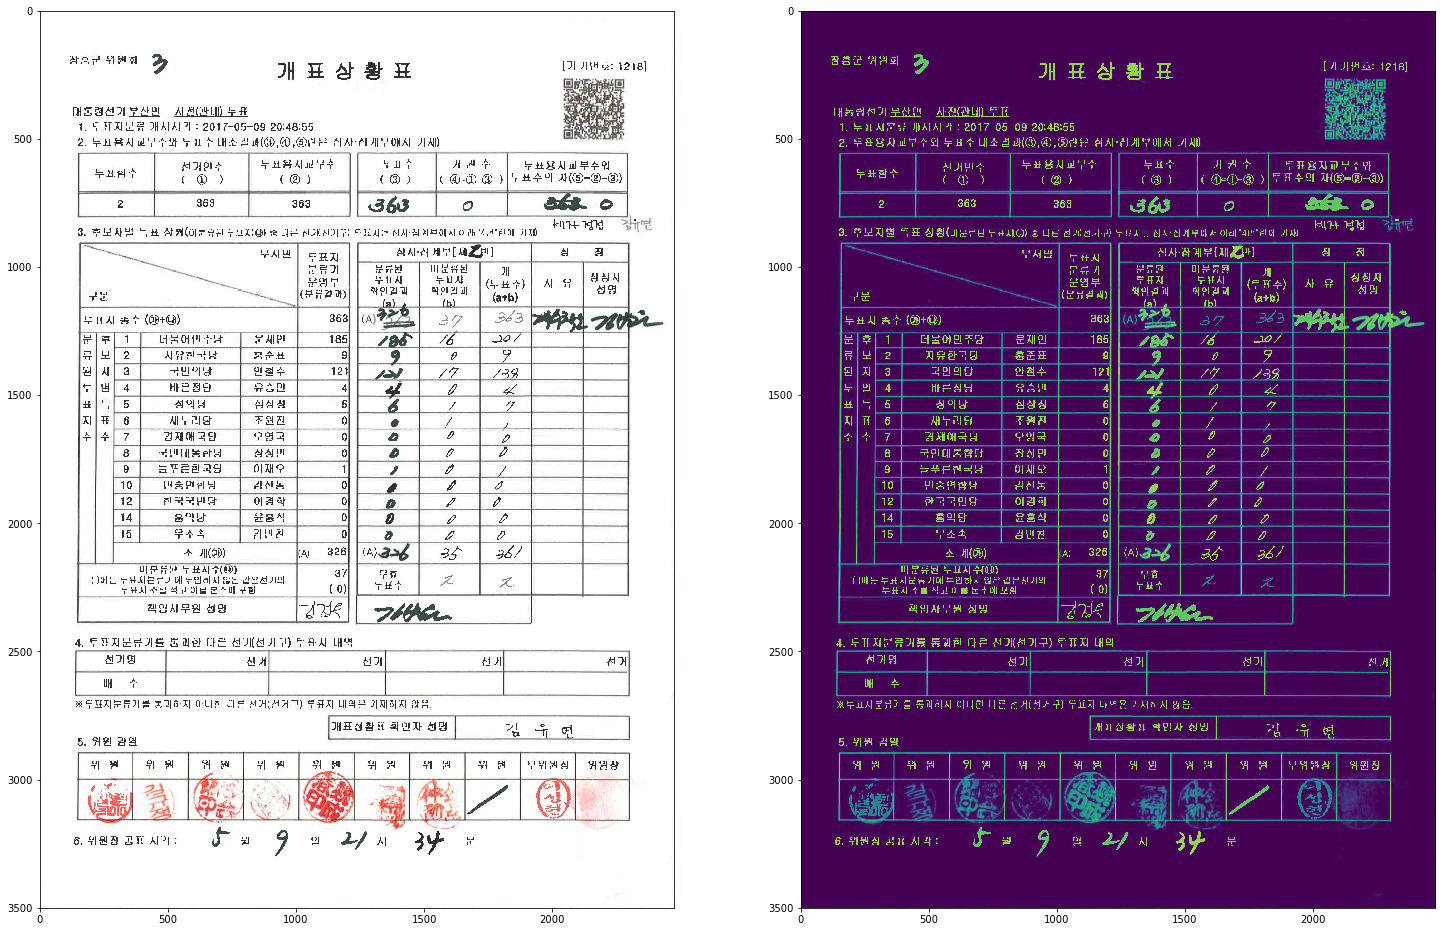

In [598]:
# print(len(table_bnds), table_bnds[1][0] - table_bnds[0][0] > gray.shape[1]//3)

# tx, ty, tw, th = table_bnds[1]

# otsu, _ = gray2bin(gray, 30)

# tgray, totsu = map(lambda v: v[ty-margin:ty+th+margin, tx-margin:tx+tw+margin], (gray, otsu))
# totsu, tdeg = rotate_straight(totsu)
# imshow(totsu)

# imshow(testimg)
im = gray_img(testimg)
rotate_straight(im)
# h, w = im.shape
# rotim = im[h//3:h*2//3]
# h, w = rotim.shape

# for x in range(w):
#     if im[h//2,x]: break

# rst, xfn, _ = angular_count(rotim, 90-10, 90+10, (None, None), (x-1, x+w//300), True)
# x0,y0, m, cnt = max(rst, key=lambda v:v[-1])
# if m != float('inf'):
#     from math import atan
#     #     print(x0, m, rad2deg(atan(m)), cnt, xfn(0, m, x0), xfn(h-1, m, x0))
#     deg = rad2deg(atan(m if m >= 0 else -m))
#     if m<0 : deg = 180-deg
#     print(deg)
# #     deg = (deg-90) if deg > 90-15 else ((deg+90)/2)
# #     if deg > 0 : deg -= 90
# #     else : deg += 90
#     deg = (deg-90) if deg<90 else (deg+90)
#     print(deg)
#     im = rotate_img(im, deg)
# # print(x0, m, deg, cnt, xfn(0, m, x0), xfn(h-1, m, x0))

plt.subplot(121).imshow(testimg)
plt.subplot(122).imshow(im)

# imshow(rotim)

# imshow(gray)
# print(len(tlines))
# print(tlines)
# gray //= 2
# for p in tlines:
#     x0, y0, x1, y1 = p[0]
#     cv2.line(gray, (x0, y0), (x1, y1), 255)
# cv2.line(gray, (xfn(0, m, x0), gray.shape[0]//3), (xfn(h-1, m, x0), gray.shape[0]*2//3-1), 255)

# otsu//=2
# cv2.line(otsu, (xfn(0, m, x0), 0), (xfn(h-1, m, x0), h-1), 255)
# imshow(otsu)
# deg = rad2deg(atan(m))
# print(deg)
# imshow(rotate_img(gray, 90+deg))